# Dynamic Pricing for Urban Parking Lots
---
Summer Analytics 2025

##  What's the Problem?

- Urban areas often face a parking crisis.
- Some parking lots are always overcrowded
- while others remain empty, even when nearby.
---
Why?
- Because parking prices are static i.e. they don’t change based on
- How full a lot is
- How heavy the traffic is
- What type of vehicle is trying to enter
- Or if it’s a holiday/event day
---

## What’s the Goal?

- building an AI-powered dynamic pricing system that updates parking fees in real time for each of 14 parking lots so that:
- Prices increase when demand is high
- Prices drop to attract drivers when demand is low
- The system learns from real-world patterns

## What Does “Dynamic Pricing” Mean?

Like how Uber or airline tickets go up in peak hours, you’ll build a system where:
- Prices adjust every 30 minutes
- Based on real-time data (occupancy, traffic, etc.)
- Starting from a base price example of $10
This makes parking smarter, fairer, and better utilized.

## Visualization

We will use Bokeh to create real-time visualizations
- Show how price changes per lot over time
- Compare prices between nearby parking lots

## Real-Time Simulation Using Pathway (We will add this in the ending to see the power of pathway vs our data analysis)

Instead of reading data all at once, we'll simulate how data arrives in real time:

- One row at a time (like streaming data)
- Pricing must update as each new row comes in
- Pathway helps manage this simulation

## Library Imports

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bp
from bokeh.io import output_notebook, show
output_notebook()

# Optional
import seaborn as sns

## Data Loading & Exploration (Please add the dataset [Click here!](https://drive.google.com/drive/folders/1ts6zhcX8hAj1X-c9HLre_giZpGT7zxT5))

In [192]:
df = pd.read_csv('/content/dataset.csv')

In [193]:
print(df.shape)

(18368, 12)


In [194]:
df.head()

ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   

  TrafficConditionNearby  QueueLength  IsSpecialDay LastUpdatedDate  \
0                    low            1             0      04-10-2016   
1                    low            1             0      04-10-2016   
2                    low            2             0      04-10-2016   
3                    low            2             0      04-10-2016   
4                    low            2             0      04-10-2016   

  LastUpdatedTime  
0        07:59:00  
1        08:25:00  
2        08:59:00  
3        09:32:00  
4        09:59:00

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


In [196]:
df.describe()

ID      Capacity      Latitude     Longitude     Occupancy  \
count  18368.000000  18368.000000  18368.000000  18368.000000  18368.000000   
mean    9183.500000   1605.214286     25.706547     90.751170    731.084059   
std     5302.529208   1131.153886      1.582749      3.536636    621.164982   
min        0.000000    387.000000     20.000035     78.000003      2.000000   
25%     4591.750000    577.000000     26.140048     91.727995    322.000000   
50%     9183.500000   1261.000000     26.147482     91.729511    568.000000   
75%    13775.250000   2803.000000     26.147541     91.736172    976.000000   
max    18367.000000   3883.000000     26.150504     91.740994   3499.000000   

        QueueLength  IsSpecialDay  
count  18368.000000  18368.000000  
mean       4.587925      0.150915  
std        2.580062      0.357975  
min        0.000000      0.000000  
25%        2.000000      0.000000  
50%        4.000000      0.000000  
75%        6.000000      0.000000  
max       15.000000      1.000000

# Model 1: Baseline Linear Model

## Formula:

$$
\text{Price}_{t+1} = \text{Price}_t + \alpha \times \left(\frac{\text{Occupancy}}{\text{Capacity}}\right)
$$

* Start with **Price = \$10**
* Use a fixed **α (alpha)** value (e.g., `0.3`) - Stable pricing for brand trust
* Ensure the price stays within reasonable bounds (e.g., `$5 to $20`)
* Calculate price **per lot**, sorted in time

In [197]:
# Combine date and time to create a timestamp
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    format='%d-%m-%Y %H:%M:%S'
)

In [198]:
# Sort data by parking lot and time
df_sorted = df.sort_values(by=['SystemCodeNumber', 'Timestamp']).copy()

In [199]:
df_sorted

ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0          0      BHMBCCMKT01       577  26.144536  91.736172         61   
1          1      BHMBCCMKT01       577  26.144536  91.736172         64   
2          2      BHMBCCMKT01       577  26.144536  91.736172         80   
3          3      BHMBCCMKT01       577  26.144536  91.736172        107   
4          4      BHMBCCMKT01       577  26.144536  91.736172        150   
...      ...              ...       ...        ...        ...        ...   
18363  18363         Shopping      1920  26.150504  91.733531       1517   
18364  18364         Shopping      1920  26.150504  91.733531       1487   
18365  18365         Shopping      1920  26.150504  91.733531       1432   
18366  18366         Shopping      1920  26.150504  91.733531       1321   
18367  18367         Shopping      1920  26.150504  91.733531       1180   

      VehicleType TrafficConditionNearby  QueueLength  IsSpecialDay  \
0             car                    low            1             0   
1             car                    low            1             0   
2             car                    low            2             0   
3             car                    low            2             0   
4            bike                    low            2             0   
...           ...                    ...          ...           ...   
18363       truck                average            6             0   
18364         car                    low            3             0   
18365       cycle                    low            3             0   
18366         car                    low            2             0   
18367         car                    low            2             0   

      LastUpdatedDate LastUpdatedTime           Timestamp  
0          04-10-2016        07:59:00 2016-10-04 07:59:00  
1          04-10-2016        08:25:00 2016-10-04 08:25:00  
2          04-10-2016        08:59:00 2016-10-04 08:59:00  
3          04-10-2016        09:32:00 2016-10-04 09:32:00  
4          04-10-2016        09:59:00 2016-10-04 09:59:00  
...               ...             ...                 ...  
18363      19-12-2016        14:30:00 2016-12-19 14:30:00  
18364      19-12-2016        15:03:00 2016-12-19 15:03:00  
18365      19-12-2016        15:29:00 2016-12-19 15:29:00  
18366      19-12-2016        16:03:00 2016-12-19 16:03:00  
18367      19-12-2016        16:30:00 2016-12-19 16:30:00  

[18368 rows x 13 columns]

In [200]:
# Set pricing parameters
alpha = 0.3 # slow, stable, profit-friendly
base_price = 10.0
min_price = 5.0
max_price = 20.0

In [201]:
# Apply pricing logic per parking lot
baseline_prices = []

In [202]:
for lot_id, lot_data in df_sorted.groupby('SystemCodeNumber'):
    price = base_price
    lot_prices = []

    for _, row in lot_data.iterrows():
        occupancy_ratio = row['Occupancy'] / row['Capacity']
        price += alpha * occupancy_ratio
        price = max(min_price, min(price, max_price))
        lot_prices.append(price)

    baseline_prices.extend(lot_prices)

In [203]:
# Add BaselinePrice to your dataframe
df_sorted['BaselinePrice'] = baseline_prices

In [204]:
# Step 6: Preview the results
df_sorted[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity', 'BaselinePrice']].head(10)

SystemCodeNumber           Timestamp  Occupancy  Capacity  BaselinePrice
0      BHMBCCMKT01 2016-10-04 07:59:00         61       577      10.031716
1      BHMBCCMKT01 2016-10-04 08:25:00         64       577      10.064991
2      BHMBCCMKT01 2016-10-04 08:59:00         80       577      10.106586
3      BHMBCCMKT01 2016-10-04 09:32:00        107       577      10.162218
4      BHMBCCMKT01 2016-10-04 09:59:00        150       577      10.240208
5      BHMBCCMKT01 2016-10-04 10:26:00        177       577      10.332236
6      BHMBCCMKT01 2016-10-04 10:59:00        219       577      10.446101
7      BHMBCCMKT01 2016-10-04 11:25:00        247       577      10.574523
8      BHMBCCMKT01 2016-10-04 11:59:00        259       577      10.709185
9      BHMBCCMKT01 2016-10-04 12:29:00        266       577      10.847487

In [205]:
# Filter for a single parking lot
first_lot = df_sorted['SystemCodeNumber'].unique()[0]
df_lot = df_sorted[df_sorted['SystemCodeNumber'] == first_lot]

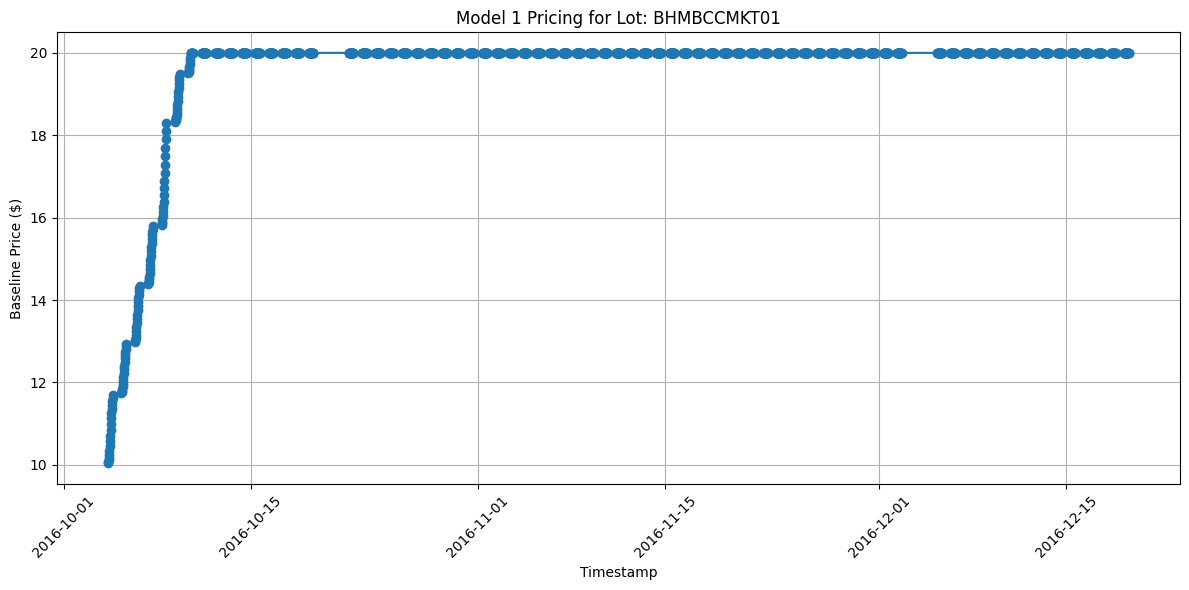

In [206]:
# Plot price over time
plt.figure(figsize=(12, 6))
plt.plot(df_lot['Timestamp'], df_lot['BaselinePrice'], marker='o', linestyle='-')
plt.title(f"Model 1 Pricing for Lot: {first_lot}")
plt.xlabel("Timestamp")
plt.ylabel("Baseline Price ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Bokeh

In [207]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import layout

In [208]:
output_notebook()

In [209]:
source = ColumnDataSource(df_lot)

In [210]:
p = figure(x_axis_type='datetime', title=f"Model 1 Pricing for Lot: {first_lot}",
           width=900, height=400)
p.line('Timestamp', 'BaselinePrice', source=source, line_width=2, color='navy', legend_label="Baseline Price")
p.scatter('Timestamp', 'BaselinePrice', source=source, size=5, color='red')
# Changed circle() to scatter()

GlyphRenderer(id='c5ee3407-956a-4d8c-8f9b-c7b30e7fefa0', ...)

In [211]:
# Style plot
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Price ($)'
p.legend.location = 'top_left'
p.grid.grid_line_alpha = 0.3

In [212]:
show(p)

## Compare Pricing for Multiple Parking Lots

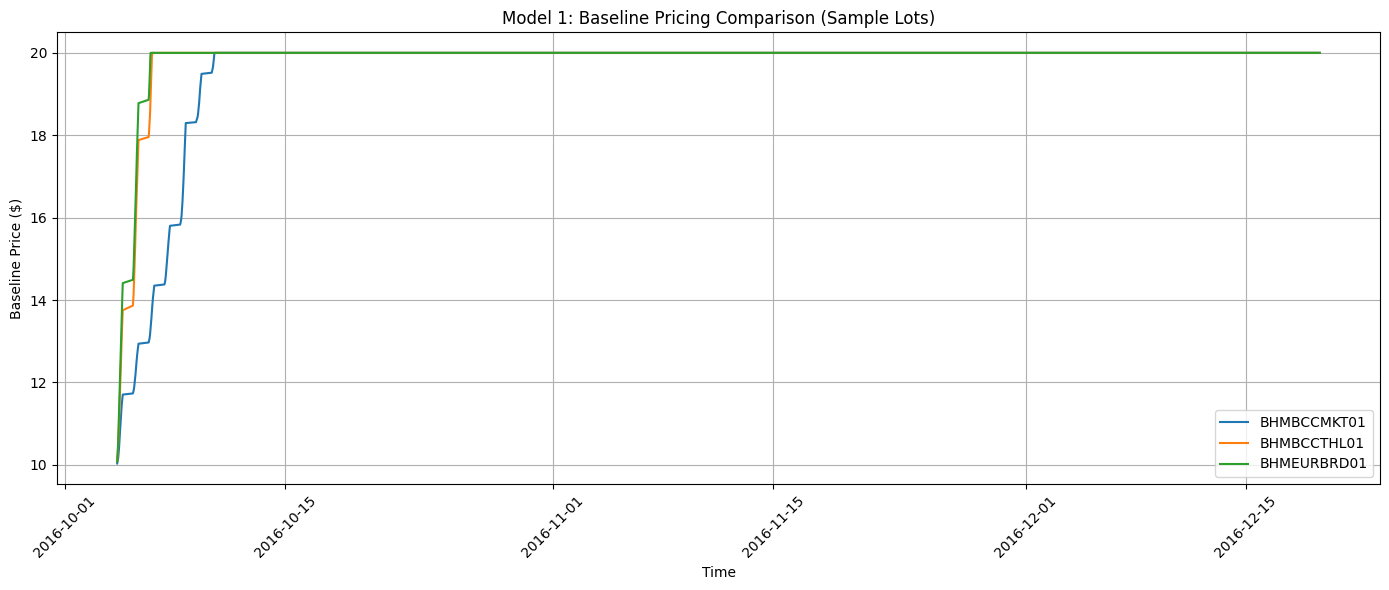

In [213]:
sample_lots = df_sorted['SystemCodeNumber'].unique()[:3]

plt.figure(figsize=(14, 6))

for lot in sample_lots:
    lot_data = df_sorted[df_sorted['SystemCodeNumber'] == lot]
    plt.plot(lot_data['Timestamp'], lot_data['BaselinePrice'], label=lot)

plt.title("Model 1: Baseline Pricing Comparison (Sample Lots)")
plt.xlabel("Time")
plt.ylabel("Baseline Price ($)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Estimate Revenue per Row

Since:

$$
\text{Revenue}_t = \text{Occupancy}_t \times \text{Price}_t
$$

We can add a `Revenue` column for each row using `BaselinePrice`.



In [214]:
# Calculate revenue per row
df_sorted['Revenue'] = df_sorted['Occupancy'] * df_sorted['BaselinePrice']

In [215]:
# Preview updated DataFrame
df_sorted[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'BaselinePrice', 'Revenue']].head(10)

SystemCodeNumber           Timestamp  Occupancy  BaselinePrice      Revenue
0      BHMBCCMKT01 2016-10-04 07:59:00         61      10.031716   611.934662
1      BHMBCCMKT01 2016-10-04 08:25:00         64      10.064991   644.159445
2      BHMBCCMKT01 2016-10-04 08:59:00         80      10.106586   808.526863
3      BHMBCCMKT01 2016-10-04 09:32:00        107      10.162218  1087.357366
4      BHMBCCMKT01 2016-10-04 09:59:00        150      10.240208  1536.031196
5      BHMBCCMKT01 2016-10-04 10:26:00        177      10.332236  1828.805719
6      BHMBCCMKT01 2016-10-04 10:59:00        219      10.446101  2287.696014
7      BHMBCCMKT01 2016-10-04 11:25:00        247      10.574523  2611.907279
8      BHMBCCMKT01 2016-10-04 11:59:00        259      10.709185  2773.679029
9      BHMBCCMKT01 2016-10-04 12:29:00        266      10.847487  2885.431542

In [216]:
# Select relevant columns
model1_output = df_sorted[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity', 'BaselinePrice', 'Revenue']]

In [217]:
# Save to CSV
model1_output.to_csv("model1_Baseline_Linear_Model_pricing_output.csv", index=False)

## Summary Documentation Cell for Model 1

### Model 1: Baseline Linear Pricing

#### Objective:

To create a simple pricing model where the parking price increases **linearly** with **occupancy**, simulating basic economic behavior (high demand → higher price).

#### Formula:

$$
\text{Price}_{t+1} = \text{Price}_t + \alpha \times \left(\frac{\text{Occupancy}}{\text{Capacity}}\right)
$$

* **Base Price:** \$10.00
* **Alpha (α):** 0.3 *(slow and profit-focused)*
* **Clipping Range:** \$5.00 to \$20.00

  * Prevents unrealistic price surges or underpricing

---

#### Assumptions:

* Occupancy ratio directly reflects real-time demand.
* Price updates are **smooth and gradual** (not erratic).
* External features like traffic and queue are **not** used in this model (reserved for Model 2).
* Occupancy data is assumed to be accurate and synced in time.

---

#### Implementation Highlights:

* Prices are calculated **per lot** and **over time** using a rolling update.
* Price is clipped between \$5 and \$20 to maintain economic realism.
* Revenue is calculated as:

$$
\text{Revenue}_t = \text{BaselinePrice}_t \times \text{Occupancy}_t
$$

---

#### Outputs:

* Column: `BaselinePrice` — dynamically updated price
* Column: `Revenue` — estimated revenue at each time step
* Visualization: Price trend vs time (per lot)
* File: `model1_baseline_pricing_output.csv` — cleaned output

---

# Model 2: Demand-Based Pricing

## Objective

Create a smarter pricing model where the price responds to **demand signals**, using:

* Occupancy Rate
* Queue Length
* Traffic Conditions
* Special Day Indicator
* Vehicle Type

## Encoding Mappings

In [218]:
df['VehicleType'].unique()

array(['car', 'bike', 'truck', 'cycle'], dtype=object)

In [219]:
# VehicleType -> VehicleTypeWeight
vehicle_weights = {
    'bike': 0.5,
    'car': 1.0,
    'truck': 1.5,
    'cycle': 0.7  # for rare type
}

In [220]:
# TrafficConditionNearby -> TrafficLevel
traffic_levels = {
    'low': 0,
    'medium': 1,
    'high': 2,
    'average': 1  # to treat 'average' like 'medium'
}

In [221]:
# Made a copy to work on Model 2
df_model2 = df_sorted.copy()

In [222]:
df_model2['VehicleTypeWeight'] = df_model2['VehicleType'].map(vehicle_weights)
df_model2['TrafficLevel'] = df_model2['TrafficConditionNearby'].map(traffic_levels)

In [223]:
df_model2[['VehicleType', 'VehicleTypeWeight', 'TrafficConditionNearby', 'TrafficLevel']].head(10)

VehicleType  VehicleTypeWeight TrafficConditionNearby  TrafficLevel
0         car                1.0                    low             0
1         car                1.0                    low             0
2         car                1.0                    low             0
3         car                1.0                    low             0
4        bike                0.5                    low             0
5         car                1.0                    low             0
6       truck                1.5                   high             2
7         car                1.0                average             1
8       cycle                0.7                average             1
9        bike                0.5                   high             2

## Define Feature Weights & Calculate Demand

$$
\text{Demand}_t = \alpha \cdot \left(\frac{\text{Occupancy}}{\text{Capacity}}\right) + \beta \cdot \text{QueueLength} - \gamma \cdot \text{TrafficLevel} + \delta \cdot \text{IsSpecialDay} + \epsilon \cdot \text{VehicleTypeWeight}
$$

---

### Weights (We can tune these later):

| Feature         | Symbol | Suggested Value | Reason                                |
| --------------- | ------ | --------------- | ------------------------------------- |
| Occupancy Ratio | α      | `1.0`           | Core demand driver                    |
| Queue Length    | β      | `0.5`           | Extra waiting implies high demand     |
| Traffic Level   | γ      | `0.3`           | High traffic may reduce desirability  |
| Special Day     | δ      | `1.0`           | Demand spikes on events/holidays      |
| Vehicle Weight  | ε      | `0.2`           | Bigger vehicles = more valuable space |


In [224]:
# Define weights
alpha = 1.0
beta = 0.5
gamma = 0.3
delta = 1.0
epsilon = 0.2

In [225]:
# Compute occupancy ratio
df_model2['OccupancyRatio'] = df_model2['Occupancy'] / df_model2['Capacity']

In [226]:
# Calculate raw demand score
df_model2['RawDemand'] = (
    alpha   * df_model2['OccupancyRatio'] +
    beta    * df_model2['QueueLength'] -
    gamma   * df_model2['TrafficLevel'] +
    delta   * df_model2['IsSpecialDay'] +
    epsilon * df_model2['VehicleTypeWeight']
)

In [227]:
df_model2[['Occupancy', 'Capacity', 'OccupancyRatio', 'QueueLength', 'TrafficLevel',
           'IsSpecialDay', 'VehicleTypeWeight', 'RawDemand']].head(10)

Occupancy  Capacity  OccupancyRatio  QueueLength  TrafficLevel  \
0         61       577        0.105719            1             0   
1         64       577        0.110919            1             0   
2         80       577        0.138648            2             0   
3        107       577        0.185442            2             0   
4        150       577        0.259965            2             0   
5        177       577        0.306759            3             0   
6        219       577        0.379549            6             2   
7        247       577        0.428076            5             1   
8        259       577        0.448873            5             1   
9        266       577        0.461005            8             2   

   IsSpecialDay  VehicleTypeWeight  RawDemand  
0             0                1.0   0.805719  
1             0                1.0   0.810919  
2             0                1.0   1.338648  
3             0                1.0   1.385442  
4             0                0.5   1.359965  
5             0                1.0   2.006759  
6             0                1.5   3.079549  
7             0                1.0   2.828076  
8             0                0.7   2.788873  
9             0                0.5   3.961005

## Normalize Demand

We want to **scale `RawDemand` into a range between 0 and 1**, so that pricing remains:

* **Smooth** (no huge jumps)
* **Bounded** (doesn’t exceed 2x or go below 0.5x base price)

---

### Method: **Min-Max Normalization**

$$
\text{NormalizedDemand}_t = \frac{\text{RawDemand}_t - \text{Min}}{\text{Max} - \text{Min}}
$$

We'll then use it in:

$$
\text{Model2Price}_t = \text{BasePrice} \cdot (1 + \lambda \cdot \text{NormalizedDemand})
$$

---

In [228]:
raw_min = df_model2['RawDemand'].min()
raw_max = df_model2['RawDemand'].max()

In [229]:
df_model2['NormalizedDemand'] = (df_model2['RawDemand'] - raw_min) / (raw_max - raw_min)

In [230]:
# Preview
df_model2[['RawDemand', 'NormalizedDemand']].head(10)

RawDemand  NormalizedDemand
0   0.805719          0.077414
1   0.810919          0.078000
2   1.338648          0.137496
3   1.385442          0.142772
4   1.359965          0.139900
5   2.006759          0.212819
6   3.079549          0.333766
7   2.828076          0.305415
8   2.788873          0.300995
9   3.961005          0.433142

### Compute Final Price Using Normalized Demand

We now apply the dynamic pricing formula:

$$
\text{Model2Price}_t = \text{BasePrice} \cdot (1 + \lambda \cdot \text{NormalizedDemand})
$$

---

In [231]:
#Final pricing
base_price = 10.0
lambda_ = 1.0  # sensitivity to normalized demand
min_price = 5.0
max_price = 20.0

In [232]:
# Compute price using normalized demand
df_model2['Model2Price'] = base_price * (1 + lambda_ * df_model2['NormalizedDemand'])

In [233]:
# Clip the price between min and max bounds
df_model2['Model2Price'] = df_model2['Model2Price'].clip(lower=min_price, upper=max_price)

In [234]:
# Preview result
df_model2[['NormalizedDemand', 'Model2Price']].head(10)

NormalizedDemand  Model2Price
0          0.077414    10.774137
1          0.078000    10.779999
2          0.137496    11.374963
3          0.142772    11.427719
4          0.139900    11.398996
5          0.212819    12.128194
6          0.333766    13.337661
7          0.305415    13.054150
8          0.300995    13.009952
9          0.433142    14.331418

# Plotting Model2Price vs Model1Price Over Time

In [235]:
# Pick a sample parking lot
sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

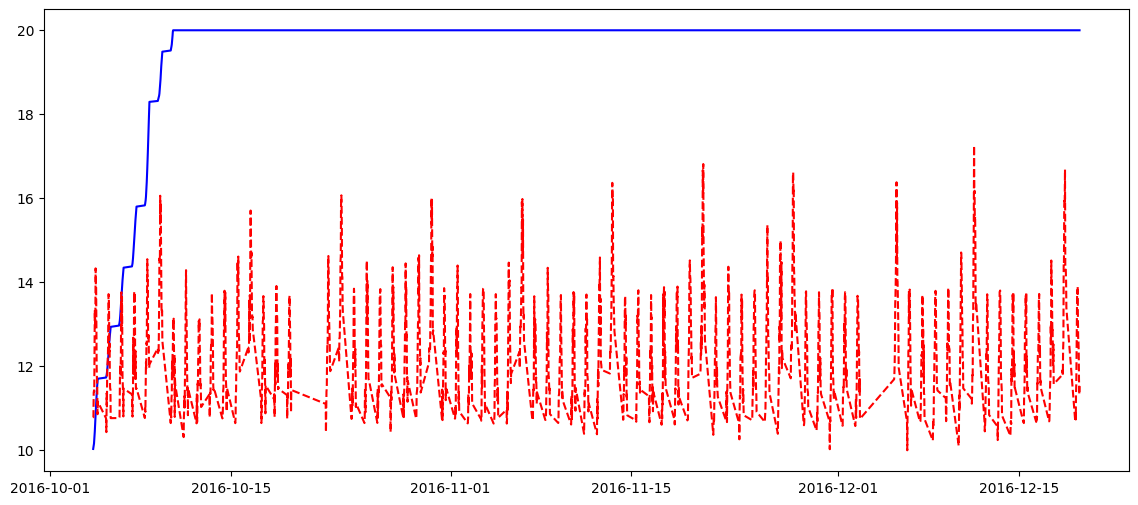

In [236]:
# Plot both models
plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['BaselinePrice'], label='Model 1: Linear', color='blue')
plt.plot(lot_data['Timestamp'], lot_data['Model2Price'], label='Model 2: Demand-Based', color='red', linestyle='--')

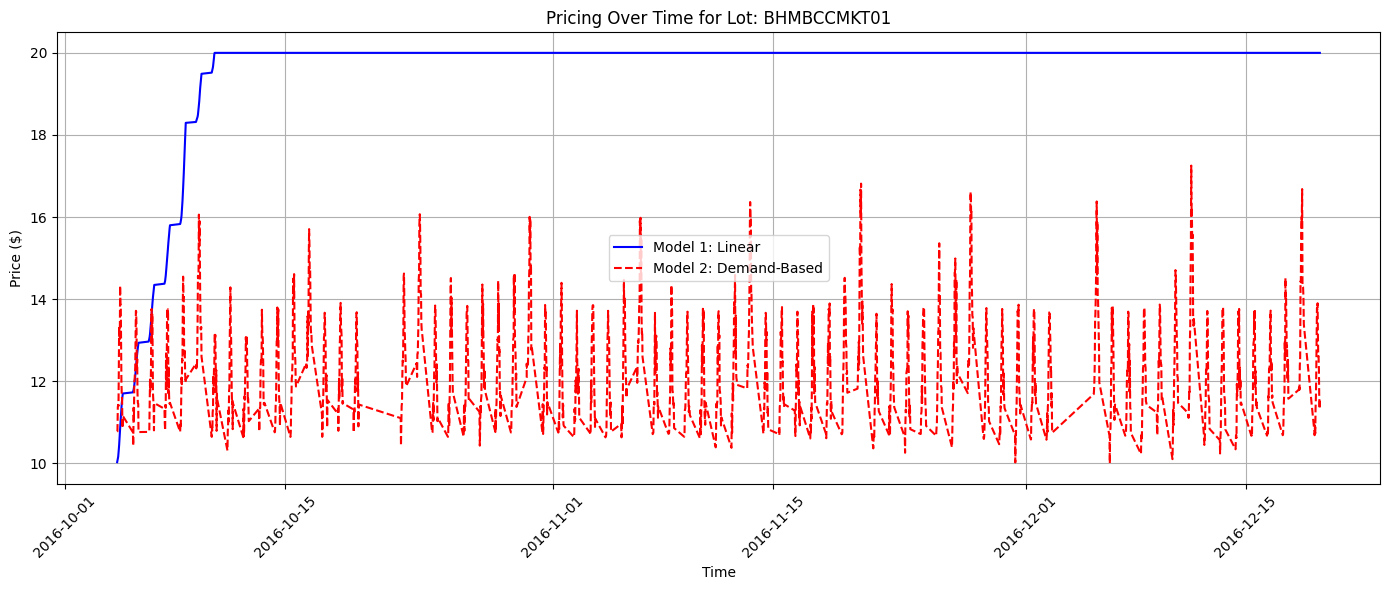

In [237]:
import matplotlib.pyplot as plt

sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['BaselinePrice'], label='Model 1: Linear', color='blue')
plt.plot(lot_data['Timestamp'], lot_data['Model2Price'], label='Model 2: Demand-Based', color='red', linestyle='--')

plt.title(f"Pricing Over Time for Lot: {sample_lot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [238]:
# Step 1: Time-based features
df_model2['Hour'] = pd.to_datetime(df_model2['Timestamp']).dt.hour
df_model2['DayOfWeek'] = pd.to_datetime(df_model2['LastUpdatedDate'], format='%d-%m-%Y').dt.dayofweek

df_model2['IsOfficeHour'] = df_model2['Hour'].between(9, 17).astype(int)
df_model2['IsWeekend'] = df_model2['DayOfWeek'].isin([5, 6]).astype(int)

In [239]:
# New weights
zeta = 0.8  # weekend effect
eta = 0.6   # office hour effect

In [240]:
# Recompute raw demand with new terms
df_model2['RawDemand'] = (
    alpha   * df_model2['OccupancyRatio'] +
    beta    * df_model2['QueueLength'] -
    gamma   * df_model2['TrafficLevel'] +
    delta   * df_model2['IsSpecialDay'] +
    epsilon * df_model2['VehicleTypeWeight'] +
    zeta    * df_model2['IsWeekend'] +
    eta     * df_model2['IsOfficeHour']
)

In [241]:
# Normalize demand again
raw_min = df_model2['RawDemand'].min()
raw_max = df_model2['RawDemand'].max()
df_model2['NormalizedDemand'] = (df_model2['RawDemand'] - raw_min) / (raw_max - raw_min)


In [242]:
# Recalculate Model2Price
df_model2['Model2Price'] = base_price * (1 + lambda_ * df_model2['NormalizedDemand'])
df_model2['Model2Price'] = df_model2['Model2Price'].clip(lower=min_price, upper=max_price)

In [243]:
# Revenue for Model 2
df_model2['Model2Revenue'] = df_model2['Model2Price'] * df_model2['Occupancy']

In [244]:
# Preview
df_model2[['Timestamp', 'IsWeekend', 'IsOfficeHour', 'RawDemand', 'NormalizedDemand', 'Model2Price']].head()

Timestamp  IsWeekend  IsOfficeHour  RawDemand  NormalizedDemand  \
0 2016-10-04 07:59:00          0             0   0.805719          0.072114   
1 2016-10-04 08:25:00          0             0   0.810919          0.072660   
2 2016-10-04 08:59:00          0             0   1.338648          0.128084   
3 2016-10-04 09:32:00          0             1   1.985442          0.196011   
4 2016-10-04 09:59:00          0             1   1.959965          0.193336   

   Model2Price  
0    10.721141  
1    10.726602  
2    11.280836  
3    11.960114  
4    11.933358

In [245]:
# Backup
df_model2['Model2Price_PreEnhancement'] = df_model2['Model2Price']

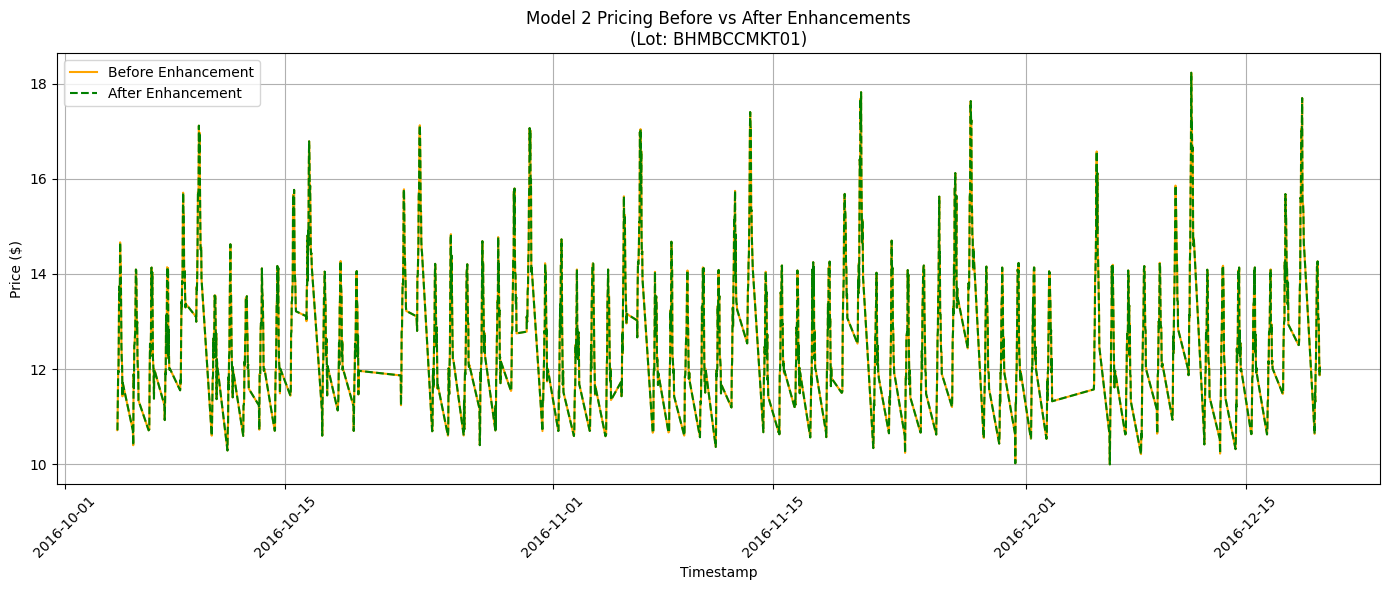

In [246]:
import matplotlib.pyplot as plt

# Pick a parking lot
sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['Model2Price_PreEnhancement'], label='Before Enhancement', color='orange')
plt.plot(lot_data['Timestamp'], lot_data['Model2Price'], label='After Enhancement', color='green', linestyle='--')

plt.title(f"Model 2 Pricing Before vs After Enhancements\n(Lot: {sample_lot})")
plt.xlabel("Timestamp")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-247-168888758.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(lot_data['Timestamp'], rotation=45)


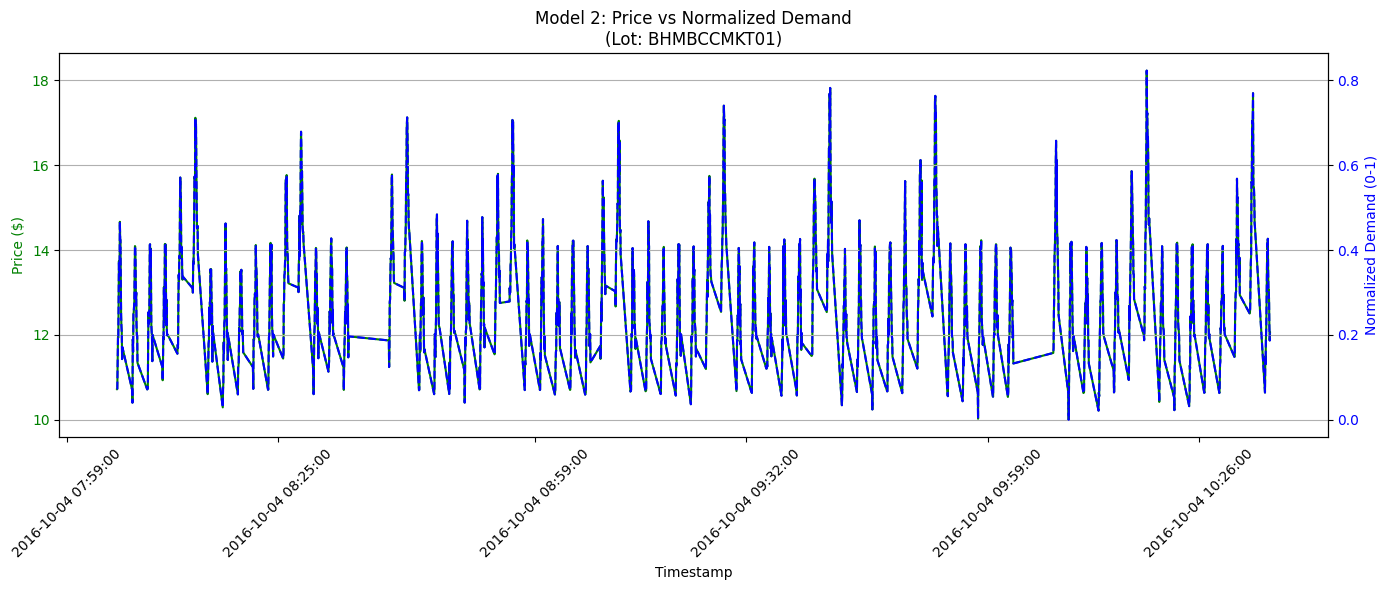

In [247]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Price line
ax1.plot(lot_data['Timestamp'], lot_data['Model2Price'], color='green', label='Model2 Price')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Price ($)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticklabels(lot_data['Timestamp'], rotation=45)

# Demand line on secondary axis
ax2 = ax1.twinx()
ax2.plot(lot_data['Timestamp'], lot_data['NormalizedDemand'], color='blue', linestyle='--', label='Normalized Demand')
ax2.set_ylabel('Normalized Demand (0-1)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and layout
plt.title(f"Model 2: Price vs Normalized Demand\n(Lot: {sample_lot})")
fig.tight_layout()
plt.grid(True)
plt.show()

In [248]:
# Choosen relevant output columns
model2_export = df_model2[[
    'SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity',
    'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType',
    'IsWeekend', 'IsOfficeHour', 'Model2Price', 'Model2Revenue'
]]

# Lets export to CSV
model2_export.to_csv("model2_Demand_Based_Price_Function_pricing_output.csv", index=False)

## Bokeh Plot: Model2Price + NormalizedDemand

In [249]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.layouts import column

output_notebook()

In [250]:
# Sample parking lot
sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

In [251]:
# Prepare Bokeh data source
source = ColumnDataSource(lot_data)

In [252]:
# Create figure with datetime x-axis
p = figure(
    x_axis_type="datetime",
    title=f"Enhanced Model 2: Price vs Normalized Demand (Lot: {sample_lot})",
    width=1000,
    height=400
)

In [253]:
# Left Y-axis: Model2 Price
p.line(x='Timestamp', y='Model2Price', source=source, color='green', line_width=2, legend_label="Model2 Price")
p.scatter(x='Timestamp', y='Model2Price', source=source, size=4, color='green')
# Changed circle() to scatter()

GlyphRenderer(id='7a48c718-c5af-4b1d-9b18-0d2cb7a6d170', ...)

In [254]:
# Right Y-axis: Normalized Demand
p.extra_y_ranges = {"demand": Range1d(start=0, end=1.1)}
p.add_layout(LinearAxis(y_range_name="demand", axis_label="Normalized Demand"), 'right')
p.line(x='Timestamp', y='NormalizedDemand', source=source, y_range_name="demand", color='blue', line_dash='dashed', line_width=2, legend_label="Normalized Demand")

GlyphRenderer(id='de5fea53-c092-432b-a133-6e09d120e602', ...)

In [255]:
# Labels & styling
p.yaxis.axis_label = "Price ($)"
p.xaxis.axis_label = "Time"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.3

In [256]:
show(p)

## Model 2: Demand-Based Dynamic Pricing

---

### Objective

To develop a smart, real-time pricing model that dynamically adjusts parking fees based on multiple **demand indicators**, capturing real-world behavior more effectively than the baseline (Model 1).

---

### Key Features Used

| Feature                 | Purpose                                           |
| ----------------------- | ------------------------------------------------- |
| **Occupancy Ratio**     | Core signal of space utilization                  |
| **Queue Length**        | Reflects pending demand                           |
| **Traffic Conditions**  | External congestion may reduce lot attractiveness |
| **Special Day Flag**    | Events/holidays drive demand surges               |
| **Vehicle Type Weight** | Larger vehicles consume more space                |
| **Weekend Indicator**   | Higher recreational demand on weekends            |
| **Office Hour Flag**    | Captures peak weekday usage (9 AM – 5 PM)         |

---

### Demand Function

The **Raw Demand** is calculated as:

$$
\text{Demand}_t = \alpha \cdot \left(\frac{\text{Occupancy}}{\text{Capacity}}\right) + \beta \cdot \text{QueueLength} - \gamma \cdot \text{TrafficLevel} + \delta \cdot \text{IsSpecialDay} + \epsilon \cdot \text{VehicleTypeWeight} + \zeta \cdot \text{IsWeekend} + \eta \cdot \text{IsOfficeHour}
$$

---

### Parameter Weights

| Symbol | Feature             | Value |
| ------ | ------------------- | ----- |
| α      | Occupancy Ratio     | 1.0   |
| β      | Queue Length        | 0.5   |
| γ      | Traffic Level       | 0.3   |
| δ      | Special Day         | 1.0   |
| ε      | Vehicle Type Weight | 0.2   |
| ζ      | Weekend             | 0.8   |
| η      | Office Hour         | 0.6   |

---

### Normalization & Pricing Formula

After computing `RawDemand`, it is **normalized using Min-Max Scaling**:

$$
\text{NormalizedDemand} = \frac{\text{Demand} - \min}{\max - \min}
$$

Then the **final dynamic price** is calculated as:

$$
\text{Price}_t = \text{BasePrice} \cdot (1 + \lambda \cdot \text{NormalizedDemand})
$$

Where:

* **BasePrice = \$10.0**
* **λ (lambda) = 1.0**
* Final price is **clipped between \$5 and \$20**

---

### Output Columns

| Column                      | Description                       |
| --------------------------- | --------------------------------- |
| `Model2Price`               | Final dynamic price per timestamp |
| `NormalizedDemand`          | Scaled demand score (0 to 1)      |
| `Model2Revenue`             | Revenue = Price × Occupancy       |
| `IsWeekend`, `IsOfficeHour` | Behavior flags for demand         |

---

### Visualizations

* Line chart comparing `Model1Price` and `Model2Price`
* Overlay of `Model2Price` and `NormalizedDemand` using **Bokeh**

---

### Benefits Over Model 1

* Captures real-world patterns (weekends, office hours)
* Handles multiple demand drivers
* Produces more adaptive and profitable pricing

---

# Model 3 : Competitive Pricing Model

## Compute Lot-to-Lot Distance Matrix

In [257]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate distance between two points on Earth (in km)
    """
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    return R * 2 * np.arcsin(np.sqrt(a))

In [258]:
lot_coords = df_model2.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first().reset_index()

radius_km = 2.0  # 2 km range
neighbor_dict = {}

for i, row1 in lot_coords.iterrows():
    neighbors = []
    for j, row2 in lot_coords.iterrows():
        if row1['SystemCodeNumber'] == row2['SystemCodeNumber']:
            continue
        distance = haversine(row1['Latitude'], row1['Longitude'], row2['Latitude'], row2['Longitude'])
        if distance <= radius_km:
            neighbors.append(row2['SystemCodeNumber'])
    neighbor_dict[row1['SystemCodeNumber']] = neighbors

In [259]:
# nearby lots
for lot_id in list(neighbor_dict.keys())[:5]:
    print(f"Lot {lot_id} has {len(neighbor_dict[lot_id])} competitors: {neighbor_dict[lot_id]}")


Lot BHMBCCMKT01 has 12 competitors: ['BHMBCCTHL01', 'BHMEURBRD01', 'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS8', 'Others-CCCPS98', 'Shopping']
Lot BHMBCCTHL01 has 12 competitors: ['BHMBCCMKT01', 'BHMEURBRD01', 'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS8', 'Others-CCCPS98', 'Shopping']
Lot BHMEURBRD01 has 12 competitors: ['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS8', 'Others-CCCPS98', 'Shopping']
Lot BHMMBMMBX01 has 0 competitors: []
Lot BHMNCPHST01 has 12 competitors: ['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS8', 'Others-CCCPS98', 'Shopping']


## For Each Row, Calculate Competitor Averages

In [260]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

lot_coords = df_model2.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first().reset_index()

neighbor_dict = {}
radius_km = 2.0

for i, lot1 in lot_coords.iterrows():
    neighbors = []
    for j, lot2 in lot_coords.iterrows():
        if lot1['SystemCodeNumber'] == lot2['SystemCodeNumber']:
            continue
        distance = haversine(lot1['Latitude'], lot1['Longitude'], lot2['Latitude'], lot2['Longitude'])
        if distance <= radius_km:
            neighbors.append(lot2['SystemCodeNumber'])
    neighbor_dict[lot1['SystemCodeNumber']] = neighbors

In [261]:
from tqdm import tqdm
import numpy as np

df_model2['NearbyAvgPrice'] = np.nan
df_model2['NearbyAvgOccupancyRatio'] = np.nan

for idx in tqdm(df_model2.index):
    row = df_model2.loc[idx]
    lot_id = row['SystemCodeNumber']
    timestamp = row['Timestamp']
    neighbors = neighbor_dict.get(lot_id, [])

    competitors = df_model2[
        (df_model2['SystemCodeNumber'].isin(neighbors)) &
        (df_model2['Timestamp'] == timestamp)
    ]

    if not competitors.empty:
        df_model2.at[idx, 'NearbyAvgPrice'] = competitors['Model2Price'].mean()
        df_model2.at[idx, 'NearbyAvgOccupancyRatio'] = (competitors['Occupancy'] / competitors['Capacity']).mean()
    else:
        df_model2.at[idx, 'NearbyAvgPrice'] = row['Model2Price']
        df_model2.at[idx, 'NearbyAvgOccupancyRatio'] = row['Occupancy'] / row['Capacity']


100%|██████████| 18368/18368 [00:53<00:00, 345.45it/s]


In [262]:
df_model2[['SystemCodeNumber', 'Timestamp', 'Model2Price', 'NearbyAvgPrice', 'Occupancy', 'NearbyAvgOccupancyRatio']].head(10)

SystemCodeNumber           Timestamp  Model2Price  NearbyAvgPrice  \
0      BHMBCCMKT01 2016-10-04 07:59:00    10.721141       11.336596   
1      BHMBCCMKT01 2016-10-04 08:25:00    10.726602       11.446810   
2      BHMBCCMKT01 2016-10-04 08:59:00    11.280836       11.670132   
3      BHMBCCMKT01 2016-10-04 09:32:00    11.960114       12.610956   
4      BHMBCCMKT01 2016-10-04 09:59:00    11.933358       12.703115   
5      BHMBCCMKT01 2016-10-04 10:26:00    12.612636       13.268749   
6      BHMBCCMKT01 2016-10-04 10:59:00    13.739306       13.623605   
7      BHMBCCMKT01 2016-10-04 11:25:00    13.475203       14.240657   
8      BHMBCCMKT01 2016-10-04 11:59:00    13.434031       14.251257   
9      BHMBCCMKT01 2016-10-04 12:29:00    14.665031       15.609927   

   Occupancy  NearbyAvgOccupancyRatio  
0         61                 0.271742  
1         64                 0.330019  
2         80                 0.417660  
3        107                 0.508493  
4        150                 0.572911  
5        177                 0.619829  
6        219                 0.666048  
7        247                 0.681926  
8        259                 0.692018  
9        266                 0.695715

## Model 3 Final Price Formula

$$
\text{Model3Price} = 0.6 \cdot \text{Model2Price} + 0.4 \cdot \text{NearbyAvgPrice} + \beta \cdot \text{NearbyAvgOccupancyRatio}
$$

* Where **β = 2.0** (This gives a boost if surrounding lots are full)
* We'll also clip the price to stay between **\$5.00 and \$20.00**

---

In [263]:
beta = 2.0

df_model2['Model3Price'] = (
    0.6 * df_model2['Model2Price'] +
    0.4 * df_model2['NearbyAvgPrice'] +
    beta * df_model2['NearbyAvgOccupancyRatio']
)

df_model2['Model3Price'] = df_model2['Model3Price'].clip(lower=5.0, upper=20.0)

In [264]:
df_model2['Model3Revenue'] = df_model2['Model3Price'] * df_model2['Occupancy']

In [265]:
df_model2[['SystemCodeNumber', 'Timestamp', 'Model2Price', 'Model3Price', 'Model3Revenue']].head(10)

SystemCodeNumber           Timestamp  Model2Price  Model3Price  \
0      BHMBCCMKT01 2016-10-04 07:59:00    10.721141    11.510807   
1      BHMBCCMKT01 2016-10-04 08:25:00    10.726602    11.674723   
2      BHMBCCMKT01 2016-10-04 08:59:00    11.280836    12.271875   
3      BHMBCCMKT01 2016-10-04 09:32:00    11.960114    13.237437   
4      BHMBCCMKT01 2016-10-04 09:59:00    11.933358    13.387083   
5      BHMBCCMKT01 2016-10-04 10:26:00    12.612636    14.114739   
6      BHMBCCMKT01 2016-10-04 10:59:00    13.739306    15.025122   
7      BHMBCCMKT01 2016-10-04 11:25:00    13.475203    15.145236   
8      BHMBCCMKT01 2016-10-04 11:59:00    13.434031    15.144958   
9      BHMBCCMKT01 2016-10-04 12:29:00    14.665031    16.434419   

   Model3Revenue  
0     702.159216  
1     747.182274  
2     981.750003  
3    1416.405774  
4    2008.062449  
5    2498.308861  
6    3290.501769  
7    3740.873205  
8    3922.544132  
9    4371.555491

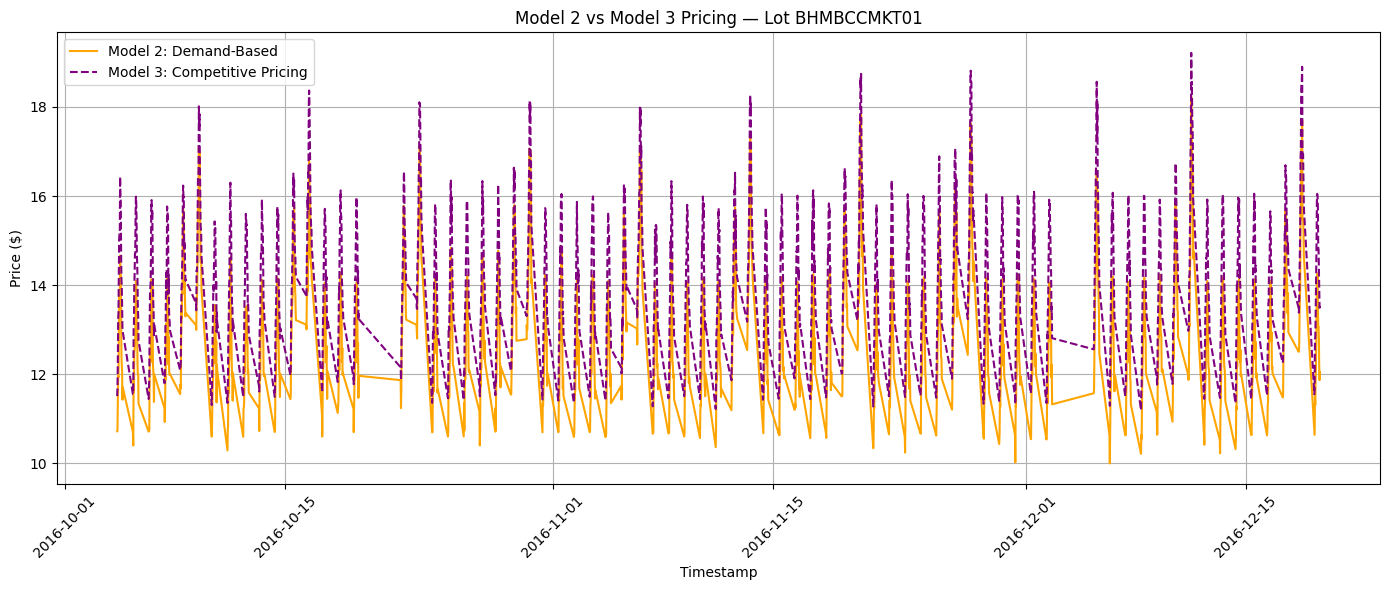

In [266]:
# Model2Price vs Model3Price
import matplotlib.pyplot as plt

# Pick parking lot
sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['Model2Price'], label='Model 2: Demand-Based', color='orange')
plt.plot(lot_data['Timestamp'], lot_data['Model3Price'], label='Model 3: Competitive Pricing', color='purple', linestyle='--')

plt.title(f"Model 2 vs Model 3 Pricing — Lot {sample_lot}")
plt.xlabel("Timestamp")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [267]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot].copy()

lot_data['Timestamp'] = pd.to_datetime(lot_data['Timestamp'])

source = ColumnDataSource(lot_data)

p = figure(x_axis_type="datetime", title=f"Model 2 vs Model 3 Pricing — Lot {sample_lot}", width=1000, height=400)

p.line(x='Timestamp', y='Model2Price', source=source, color='orange', line_width=2, legend_label='Model 2 Price')

p.line(x='Timestamp', y='Model3Price', source=source, color='purple', line_width=2, line_dash='dashed', legend_label='Model 3 Price')

p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price ($)"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.3

show(p)

In [268]:
#CSV Exporting
model3_export = df_model2[[
    'SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity',
    'Model1Price' if 'Model1Price' in df_model2.columns else 'BaselinePrice',
    'Model2Price', 'Model3Price', 'Model3Revenue',
    'NearbyAvgPrice', 'NearbyAvgOccupancyRatio'
]]

model3_export.to_csv("model3_Competitive_Pricing_Model_output.csv", index=False)

## Price vs Occupancy Plot for Model 3

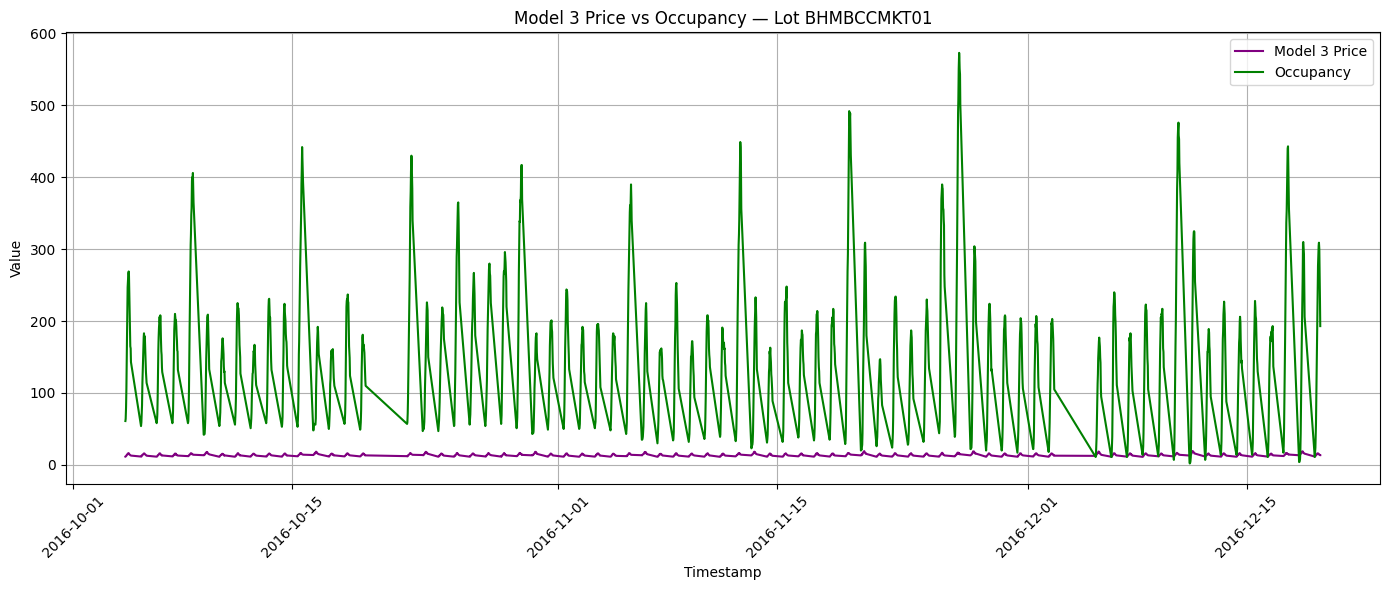

In [269]:
plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['Model3Price'], label='Model 3 Price', color='purple')
plt.plot(lot_data['Timestamp'], lot_data['Occupancy'], label='Occupancy', color='green')

plt.title(f"Model 3 Price vs Occupancy — Lot {sample_lot}")
plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model 3: Competitive Pricing

---

### Objective

To enhance the dynamic pricing strategy by making it location-aware and competitor-sensitive. This model adjusts parking prices in real time based on the prices and occupancy levels of nearby lots, simulating real-world business competition.

---

### Core Idea

> “Don’t just respond to your own demand adapt your price based on what your neighbors are doing.”

---

### Key Concepts

| Feature                   | Description                                      |
| ------------------------- | ------------------------------------------------ |
| `Latitude & Longitude`    | Used to find nearby parking lots                 |
| `NearbyAvgPrice`          | Average Model 2 price of competitors within 2 km |
| `NearbyAvgOccupancyRatio` | Avg occupancy ratio (demand) of nearby lots      |
| `Model2Price`             | Price based on demand from Model 2               |

---

### Competitive Pricing Logic

The final Model 3 price is calculated as:

$$
\text{Model3Price} = 0.6 \cdot \text{Model2Price} + 0.4 \cdot \text{NearbyAvgPrice} + \beta \cdot \text{NearbyAvgOccupancyRatio}
$$

* **β = 2.0** (tunable weight for competitor occupancy pressure)
* Final price is **clipped between \$5 \ and \$20**

---

### Interpretation

| Situation                             | Pricing Behavior                               |
| ------------------------------------- | -----------------------------------------------|
| Nearby lots are full + expensive      | Raise price — stay competitive yet profitable |
| Nearby lots are empty + cheap         | Lower price — attract demand or reroute       |
| Your lot is empty but others are full | Moderate — follow competitor trend            |

---

### Features Engineered

| Feature                         | Column                                    |
| ------------------------------- | ----------------------------------------- |
| Distance-based neighbor mapping | `neighbor_dict`                           |
| Nearby average price            | `NearbyAvgPrice`                          |
| Nearby average demand           | `NearbyAvgOccupancyRatio`                 |
| Final competitive price         | `Model3Price`                             |
| Revenue estimate                | `Model3Revenue = Model3Price × Occupancy` |

---

### Visualizations

* Model 2 vs Model 3 price trends (Matplotlib & Bokeh)
* Price vs Occupancy patterns
* Location-driven pricing behavior

---

### Key Advantages

* **Simulates market competition**
* Uses **geospatial intelligence** for dynamic pricing
* Adds **business logic** and real-world adaptability
* Avoids overpricing or underpricing in a dense parking network

---

## Summary: Model 1 vs Model 2 vs Model 3

| Feature / Behavior                      | Model 1: Baseline Linear | Model 2: Demand-Based                                                   | Model 3: Competitive Pricing                        |
| --------------------------------------- | ------------------------ | ----------------------------------------------------------------------- | --------------------------------------------------- |
| **Inputs Used**                         | Occupancy                | Occupancy, Queue, Traffic, SpecialDay, VehicleType, Weekend, OfficeHour | All Model 2 inputs + Nearby lots (price, occupancy) |
| **Time-Aware?**                         |  No                     |  Yes (office hours, weekend)                                           |  Yes                                               |
| **Location-Aware?**                     |  No                     |  No                                                                    |  Yes (lat-long neighbors)                          |
| **Price Adjusts with Local Demand?**    |  Basic (linearly)       |  Smartly                                                               |  Smart + competitive                               |
| **Price Influenced by Competitors?**    |  No                     |  No                                                                    |  Yes                                               |
| **Complexity Level**                    | ⭐ (Simple)               | ⭐⭐⭐ (Intermediate)                                                      | ⭐⭐⭐⭐ (Advanced, realistic)                          |
| **Revenue Estimation**                  | Yes                        | Yes                                                                     | Yes                                                  |
| **Adaptability to Real-World Use Case** | Limited                | Strong                                                                | Excellent (market-driven)                         |

---

# Real-Time Simulation with Pathway

In [297]:
!pip install pathway bokeh --quiet

In [298]:
!pip install -U pathway

In [299]:
# Again Importing to check everything works below
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

In [300]:
df

ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0          0      BHMBCCMKT01       577  26.144536  91.736172         61   
1       5248      BHMNCPHST01      1200  26.140014  91.731000        237   
2       3936      BHMMBMMBX01       687  20.000035  78.000003        264   
3       6560      BHMNCPNST01       485  26.140048  91.730972        249   
4      17056         Shopping      1920  26.150504  91.733531        614   
...      ...              ...       ...        ...        ...        ...   
18363   3935      BHMEURBRD01       470  26.149020  91.739503        373   
18364   2623      BHMBCCTHL01       387  26.144495  91.736205        387   
18365   1311      BHMBCCMKT01       577  26.144536  91.736172        193   
18366  17055   Others-CCCPS98      3103  26.147500  91.727978       1671   
18367  18367         Shopping      1920  26.150504  91.733531       1180   

      VehicleType TrafficConditionNearby  QueueLength  IsSpecialDay  \
0             car                    low            1             0   
1            bike                    low            2             0   
2             car                    low            2             0   
3             car                    low            2             0   
4           cycle                    low            2             0   
...           ...                    ...          ...           ...   
18363         car                    low            2             0   
18364         car                    low            2             0   
18365       cycle                    low            2             0   
18366         car                    low            3             0   
18367         car                    low            2             0   

      LastUpdatedDate LastUpdatedTime           Timestamp  
0          04-10-2016        07:59:00 2016-10-04 07:59:00  
1          04-10-2016        07:59:00 2016-10-04 07:59:00  
2          04-10-2016        07:59:00 2016-10-04 07:59:00  
3          04-10-2016        07:59:00 2016-10-04 07:59:00  
4          04-10-2016        07:59:00 2016-10-04 07:59:00  
...               ...             ...                 ...  
18363      19-12-2016        16:30:00 2016-12-19 16:30:00  
18364      19-12-2016        16:30:00 2016-12-19 16:30:00  
18365      19-12-2016        16:30:00 2016-12-19 16:30:00  
18366      19-12-2016        16:30:00 2016-12-19 16:30:00  
18367      19-12-2016        16:30:00 2016-12-19 16:30:00  

[18368 rows x 13 columns]

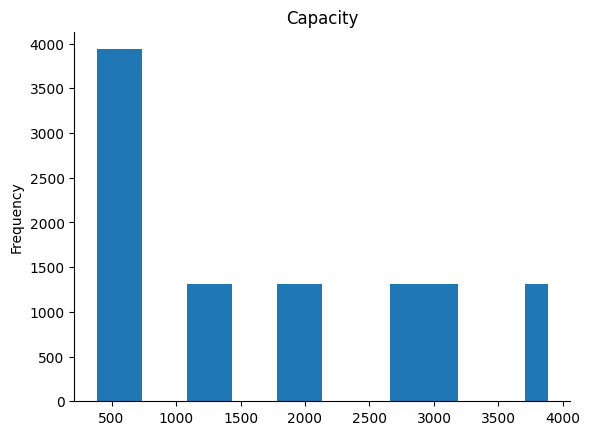

In [301]:
# @title Capacity

from matplotlib import pyplot as plt
df['Capacity'].plot(kind='hist', bins=20, title='Capacity')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [302]:
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

df = df.sort_values('Timestamp').reset_index(drop=True)

In [303]:
# Save the selected columns to a CSV file for streaming or downstream processing
df[["Timestamp", "Occupancy", "Capacity"]].to_csv("parking_stream.csv", index=False)

# Model Performance Evaluation & Comparison


### 1. Revenue Performance Comparison

# Calculate total revenue for each model

In [304]:
model1_total_revenue = df_sorted['Revenue'].sum()
model2_total_revenue = df_model2['Model2Revenue'].sum()
model3_total_revenue = df_model2['Model3Revenue'].sum()

print("=== REVENUE PERFORMANCE COMPARISON ===")
print(f"Model 1 (Baseline): ${model1_total_revenue:,.2f}")
print(f"Model 2 (Demand-Based): ${model2_total_revenue:,.2f}")
print(f"Model 3 (Competitive): ${model3_total_revenue:,.2f}")
print(f"\nRevenue Improvement:")
print(f"Model 2 vs Model 1: {((model2_total_revenue/model1_total_revenue - 1) * 100):.2f}%")
print(f"Model 3 vs Model 1: {((model3_total_revenue/model1_total_revenue - 1) * 100):.2f}%")
print(f"Model 3 vs Model 2: {((model3_total_revenue/model2_total_revenue - 1) * 100):.2f}%")

=== REVENUE PERFORMANCE COMPARISON ===
Model 1 (Baseline): $264,884,048.56
Model 2 (Demand-Based): $188,203,234.48
Model 3 (Competitive): $201,525,149.30

Revenue Improvement:
Model 2 vs Model 1: -28.95%
Model 3 vs Model 1: -23.92%
Model 3 vs Model 2: 7.08%


### 2. Occupancy Optimization Analysis

In [305]:
# Calculate average occupancy rates and utilization efficiency
def calculate_utilization_metrics(df, price_col, revenue_col):
    """Calculate occupancy utilization metrics"""
    avg_occupancy_rate = (df['Occupancy'] / df['Capacity']).mean()
    avg_price = df[price_col].mean()
    revenue_per_space = df[revenue_col].sum() / df['Capacity'].sum()
    price_volatility = df[price_col].std() / df[price_col].mean()

    return {
        'avg_occupancy_rate': avg_occupancy_rate,
        'avg_price': avg_price,
        'revenue_per_space': revenue_per_space,
        'price_volatility': price_volatility
    }

# Calculate metrics for each model
model1_metrics = calculate_utilization_metrics(df_sorted, 'BaselinePrice', 'Revenue')
model2_metrics = calculate_utilization_metrics(df_model2, 'Model2Price', 'Model2Revenue')
model3_metrics = calculate_utilization_metrics(df_model2, 'Model3Price', 'Model3Revenue')

In [306]:
print("\n=== OCCUPANCY & UTILIZATION METRICS ===")
print(f"{'Metric':<25} {'Model 1':<12} {'Model 2':<12} {'Model 3':<12}")
print("-" * 65)
print(f"{'Avg Occupancy Rate':<25} {model1_metrics['avg_occupancy_rate']:.3f}     {model2_metrics['avg_occupancy_rate']:.3f}     {model3_metrics['avg_occupancy_rate']:.3f}")
print(f"{'Avg Price ($)':<25} {model1_metrics['avg_price']:.2f}     {model2_metrics['avg_price']:.2f}     {model3_metrics['avg_price']:.2f}")
print(f"{'Revenue per Space ($)':<25} {model1_metrics['revenue_per_space']:.2f}     {model2_metrics['revenue_per_space']:.2f}     {model3_metrics['revenue_per_space']:.2f}")
print(f"{'Price Volatility':<25} {model1_metrics['price_volatility']:.3f}     {model2_metrics['price_volatility']:.3f}     {model3_metrics['price_volatility']:.3f}")



=== OCCUPANCY & UTILIZATION METRICS ===
Metric                    Model 1      Model 2      Model 3     
-----------------------------------------------------------------
Avg Occupancy Rate        0.509     0.509     0.509
Avg Price ($)             19.72     13.69     14.71
Revenue per Space ($)     8.98     6.38     6.83
Price Volatility          0.067     0.114     0.109


### 3. Price Stability Analysis

In [307]:
# Calculate price stability metrics
def calculate_price_stability(df, price_col):
    """Calculate price stability metrics"""
    price_changes = df[price_col].diff().abs()
    max_price_change = price_changes.max()
    avg_price_change = price_changes.mean()
    price_change_std = price_changes.std()

    return {
        'max_price_change': max_price_change,
        'avg_price_change': avg_price_change,
        'price_change_std': price_change_std
    }

model1_stability = calculate_price_stability(df_sorted, 'BaselinePrice')
model2_stability = calculate_price_stability(df_model2, 'Model2Price')
model3_stability = calculate_price_stability(df_model2, 'Model3Price')

print("\n=== PRICE STABILITY ANALYSIS ===")
print(f"{'Metric':<25} {'Model 1':<12} {'Model 2':<12} {'Model 3':<12}")
print("-" * 65)
print(f"{'Max Price Change ($)':<25} {model1_stability['max_price_change']:.3f}     {model2_stability['max_price_change']:.3f}     {model3_stability['max_price_change']:.3f}")
print(f"{'Avg Price Change ($)':<25} {model1_stability['avg_price_change']:.3f}     {model2_stability['avg_price_change']:.3f}     {model3_stability['avg_price_change']:.3f}")
print(f"{'Price Change Std ($)':<25} {model1_stability['price_change_std']:.3f}     {model2_stability['price_change_std']:.3f}     {model3_stability['price_change_std']:.3f}")



=== PRICE STABILITY ANALYSIS ===
Metric                    Model 1      Model 2      Model 3     
-----------------------------------------------------------------
Max Price Change ($)      9.979     4.578     4.910
Avg Price Change ($)      0.015     0.594     0.593
Price Change Std ($)      0.266     0.555     0.548


### 4. Visual Performance Comparison

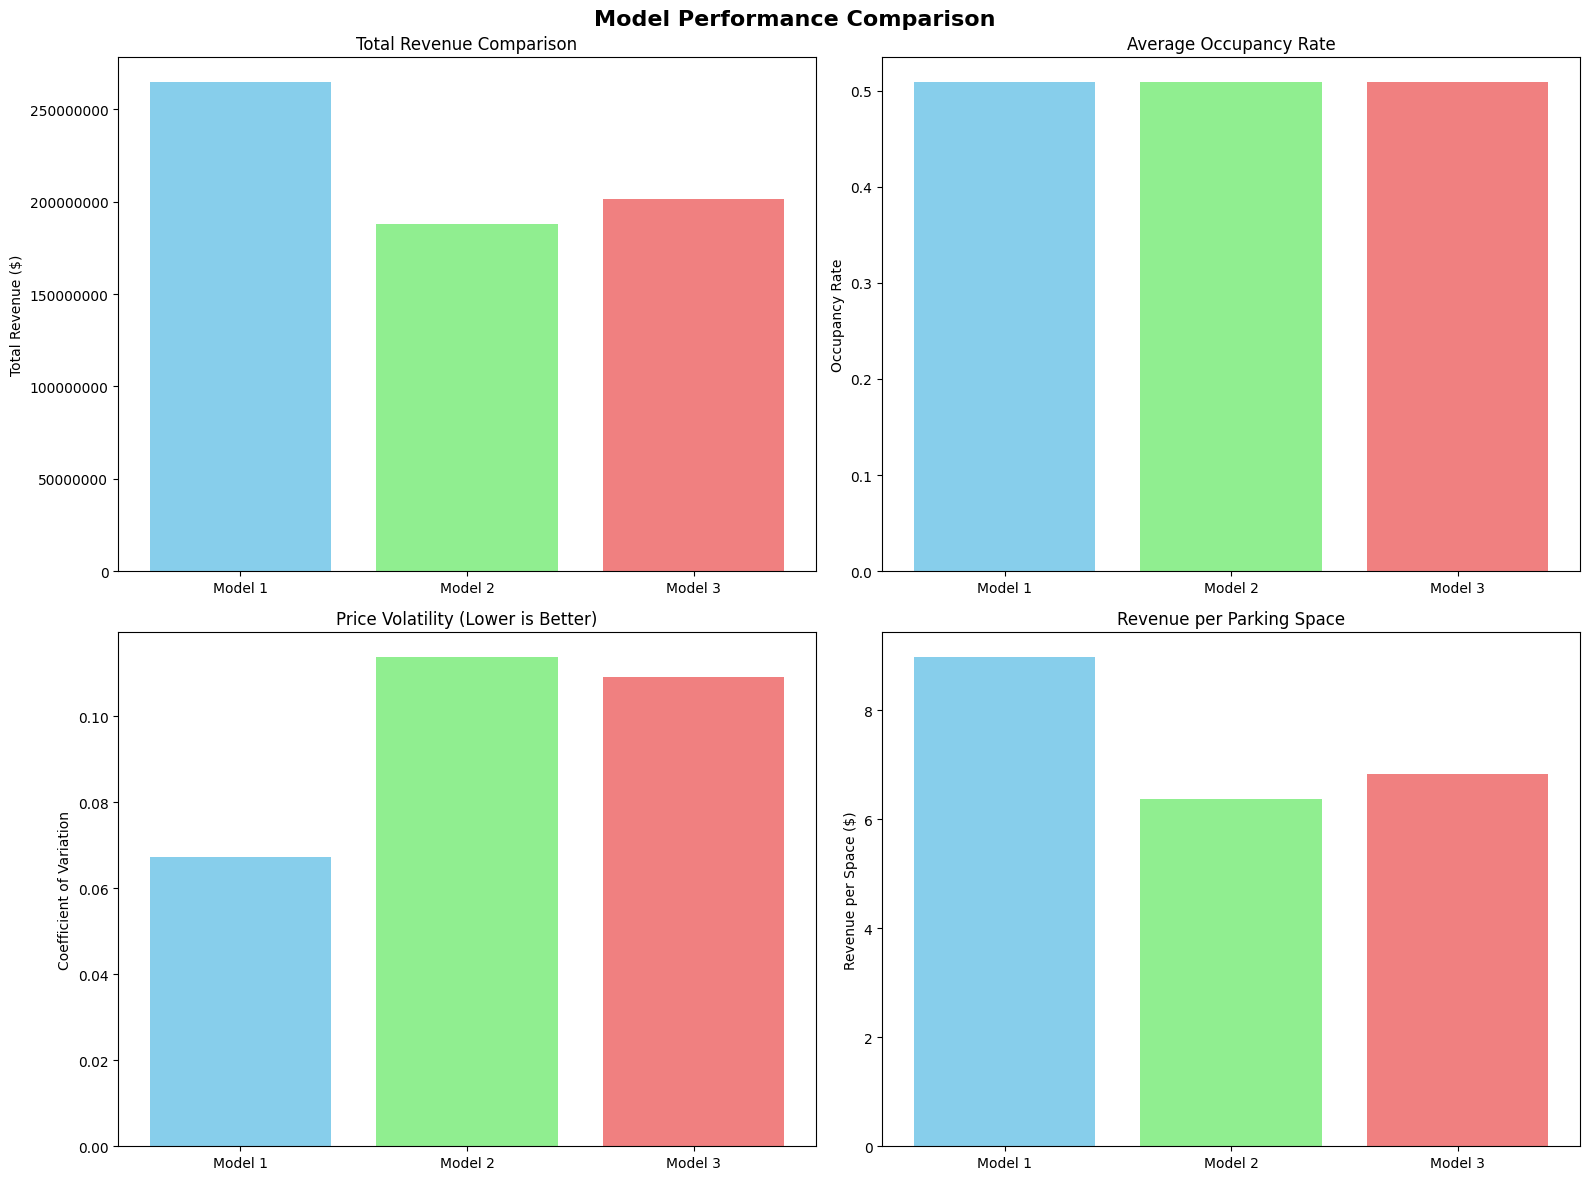

In [308]:
# Create comprehensive performance comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Revenue comparison
axes[0, 0].bar(['Model 1', 'Model 2', 'Model 3'],
               [model1_total_revenue, model2_total_revenue, model3_total_revenue],
               color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_title('Total Revenue Comparison')
axes[0, 0].set_ylabel('Total Revenue ($)')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# Occupancy rate comparison
axes[0, 1].bar(['Model 1', 'Model 2', 'Model 3'],
               [model1_metrics['avg_occupancy_rate'], model2_metrics['avg_occupancy_rate'], model3_metrics['avg_occupancy_rate']],
               color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_title('Average Occupancy Rate')
axes[0, 1].set_ylabel('Occupancy Rate')

# Price volatility comparison
axes[1, 0].bar(['Model 1', 'Model 2', 'Model 3'],
               [model1_metrics['price_volatility'], model2_metrics['price_volatility'], model3_metrics['price_volatility']],
               color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 0].set_title('Price Volatility (Lower is Better)')
axes[1, 0].set_ylabel('Coefficient of Variation')

# Revenue per space comparison
axes[1, 1].bar(['Model 1', 'Model 2', 'Model 3'],
               [model1_metrics['revenue_per_space'], model2_metrics['revenue_per_space'], model3_metrics['revenue_per_space']],
               color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 1].set_title('Revenue per Parking Space')
axes[1, 1].set_ylabel('Revenue per Space ($)')

plt.tight_layout()
plt.show()

# Smart Rerouting System

## Intelligent Rerouting Recommendations

### 1. Rerouting Logic Implementation

In [309]:
def generate_rerouting_suggestions(df, lot_id, timestamp, max_distance_km=5.0, max_price_multiplier=1.5):
    """
    Generate intelligent rerouting suggestions for a specific lot and time.

    Parameters:
    - df: DataFrame with all parking data
    - lot_id: Current parking lot ID
    - timestamp: Current timestamp
    - max_distance_km: Maximum distance for suggestions (default 5km)
    - max_price_multiplier: Maximum price multiplier for suggestions (default 1.5x)

    Returns:
    - List of rerouting suggestions with reasons
    """

    # Get current lot data
    current_lot_data = df[(df['SystemCodeNumber'] == lot_id) & (df['Timestamp'] == timestamp)]

    if current_lot_data.empty:
        return []

    current_lot = current_lot_data.iloc[0]
    current_occupancy_ratio = current_lot['Occupancy'] / current_lot['Capacity']
    current_price = current_lot['Model3Price']  # Use Model 3 price as reference

    # Get coordinates of current lot
    current_lat = current_lot['Latitude']
    current_lon = current_lot['Longitude']

    # Find nearby lots within max_distance_km
    suggestions = []

    for _, lot in df[df['Timestamp'] == timestamp].iterrows():
        if lot['SystemCodeNumber'] == lot_id:
            continue

        # Calculate distance
        distance = haversine(current_lat, current_lon, lot['Latitude'], lot['Longitude'])

        if distance <= max_distance_km:
            lot_occupancy_ratio = lot['Occupancy'] / lot['Capacity']
            lot_price = lot['Model3Price']

            # Determine suggestion reason
            reason = ""
            priority = 0

            if lot_occupancy_ratio < 0.8 and lot_price <= current_price * max_price_multiplier:
                if lot_occupancy_ratio < 0.5:
                    reason = "Excellent alternative: Low occupancy, reasonable price"
                    priority = 1
                elif lot_occupancy_ratio < 0.7:
                    reason = "Good alternative: Moderate occupancy, competitive price"
                    priority = 2
                else:
                    reason = "Decent alternative: Available space, acceptable price"
                    priority = 3
            elif lot_occupancy_ratio < 0.9 and lot_price < current_price:
                reason = "Budget option: Higher occupancy but lower price"
                priority = 4
            elif lot_occupancy_ratio < 0.6:
                reason = "Space available: Low occupancy but higher price"
                priority = 5

            if reason:
                suggestions.append({
                    'lot_id': lot['SystemCodeNumber'],
                    'distance_km': distance,
                    'occupancy_ratio': lot_occupancy_ratio,
                    'price': lot_price,
                    'reason': reason,
                    'priority': priority
                })

    # Sort by priority and distance
    suggestions.sort(key=lambda x: (x['priority'], x['distance_km']))
    return suggestions[:5]  # Return top 5 suggestions

### 2. Test Rerouting System

In [354]:
# Test rerouting for a specific scenario
test_lot = df_model2['SystemCodeNumber'].iloc[0]
test_timestamp = df_model2['Timestamp'].iloc[1000]  # Pick a middle timestamp

print(f"=== REROUTING SUGGESTIONS ===")
print(f"Current Lot: {test_lot}")
print(f"Timestamp: {test_timestamp}")
print(f"Current Status:")

current_status = df_model2[(df_model2['SystemCodeNumber'] == test_lot) &
                          (df_model2['Timestamp'] == test_timestamp)].iloc[0]

print(f"  - Occupancy: {current_status['Occupancy']}/{current_status['Capacity']} ({current_status['Occupancy']/current_status['Capacity']:.1%})")
print(f"  - Current Price: ${current_status['Model3Price']:.2f}")
print(f"  - Traffic Condition: {current_status['TrafficConditionNearby']}")

suggestions = generate_rerouting_suggestions(df_model2, test_lot, test_timestamp)

if suggestions:
    print(f"\nTop Rerouting Suggestions:")
    for i, suggestion in enumerate(suggestions, 1):
        print(f"{i}. {suggestion['lot_id']} ({suggestion['distance_km']:.1f}km away)")
        print(f"   - Occupancy: {suggestion['occupancy_ratio']:.1%}")
        print(f"   - Price: ${suggestion['price']:.2f}")
        print(f"   - Reason: {suggestion['reason']}")
        print()
else:
    print("No suitable alternatives found within 5km radius.")

=== REROUTING SUGGESTIONS ===
Current Lot: BHMBCCMKT01
Timestamp: 2016-11-30 13:01:00
Current Status:
  - Occupancy: 204/577 (35.4%)
  - Current Price: $15.77
  - Traffic Condition: high
No suitable alternatives found within 5km radius.


In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [357]:
try:
    import pathway as pw
    import bokeh.plotting
    import panel as pn
    from bokeh.plotting import figure, show
    from bokeh.io import output_notebook
    from bokeh.models import HoverTool, ColorBar
    from bokeh.palettes import Viridis256
    from bokeh.transform import linear_cmap
    pathway_available = True
    print("Pathway and Bokeh imports successful!")
except ImportError as e:
    pathway_available = False
    print(f"Pathway/Bokeh not available: {e}")

Pathway and Bokeh imports successful!


In [361]:
def prepare_pathway_data(df):
    """Prepare data for Pathway streaming with error handling"""
    try:
        df = df.copy()

        # Ensure Timestamp column exists and is datetime
        if 'Timestamp' not in df.columns:
            raise ValueError("Timestamp column not found in dataframe")

        # Convert to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Convert to string format for Pathway
        df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

        # Required columns for Pathway
        required_cols = ['Timestamp', 'SystemCodeNumber', 'Occupancy', 'Capacity', 'QueueLength',
                        'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Latitude', 'Longitude']

        # Add missing columns with defaults
        for col in required_cols:
            if col not in df.columns:
                if col == 'QueueLength':
                    df[col] = 0
                elif col == 'TrafficConditionNearby':
                    df[col] = 'Medium'
                elif col == 'IsSpecialDay':
                    df[col] = 0
                elif col == 'VehicleType':
                    df[col] = 'car'
                elif col in ['Latitude', 'Longitude']:
                    df[col] = 0.0
                else:
                    df[col] = ''

        # Save for Pathway
        df.to_csv("parking_stream.csv", index=False)
        print(f"Prepared {len(df)} rows for Pathway streaming")
        return df

    except Exception as e:
        print(f"Error preparing Pathway data: {e}")
        return None


In [362]:
df

ID  SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0          0       BHMBCCMKT01       577  26.144536  91.736172         61   
1      15744    Others-CCCPS98      3103  26.147500  91.727978        588   
2      13120   Others-CCCPS202      2937  26.147491  91.727997        547   
3      11808  Others-CCCPS135a      3883  26.147499  91.728005       1081   
4      10496  Others-CCCPS119a      2803  26.147541  91.727970        195   
...      ...               ...       ...        ...        ...        ...   
18363  15743     Others-CCCPS8      1322  26.147549  91.727995        806   
18364   9183      Broad Street       690  26.137958  91.740994        540   
18365  17055    Others-CCCPS98      3103  26.147500  91.727978       1671   
18366  10495  Others-CCCPS105a      2009  26.147473  91.728049       1345   
18367  18367          Shopping      1920  26.150504  91.733531       1180   

      VehicleType TrafficConditionNearby  QueueLength  IsSpecialDay  \
0             car                    low            1             0   
1             car                average            2             0   
2            bike                    low            2             0   
3             car                    low            2             0   
4             car                    low            1             0   
...           ...                    ...          ...           ...   
18363         car                average            3             0   
18364         car                average            3             0   
18365         car                    low            3             0   
18366        bike                    low            2             0   
18367         car                    low            2             0   

      LastUpdatedDate LastUpdatedTime           Timestamp  
0          04-10-2016        07:59:00 2016-10-04 07:59:00  
1          04-10-2016        07:59:00 2016-10-04 07:59:00  
2          04-10-2016        07:59:00 2016-10-04 07:59:00  
3          04-10-2016        07:59:00 2016-10-04 07:59:00  
4          04-10-2016        07:59:00 2016-10-04 07:59:00  
...               ...             ...                 ...  
18363      19-12-2016        16:30:00 2016-12-19 16:30:00  
18364      19-12-2016        16:30:00 2016-12-19 16:30:00  
18365      19-12-2016        16:30:00 2016-12-19 16:30:00  
18366      19-12-2016        16:30:00 2016-12-19 16:30:00  
18367      19-12-2016        16:30:00 2016-12-19 16:30:00  

[18368 rows x 13 columns]

In [363]:
def calculate_model1_price(occupancy, capacity, base_price=10.0, alpha=0.1):
    """Calculate Model 1 (Baseline) price"""
    try:
        if capacity <= 0:
            return base_price
        occupancy_ratio = occupancy / capacity
        return base_price + alpha * occupancy_ratio
    except Exception as e:
        print(f"Error in Model 1 calculation: {e}")
        return base_price

In [364]:
base_price

10.0

In [365]:
def calculate_model2_price(occupancy, capacity, queue_length, traffic, special, vehicle, base_price=10.0, lambda_=1.0):
    """Calculate Model 2 (Demand-Based) price"""
    try:
        if capacity <= 0:
            return base_price

        alpha, beta, gamma, delta, epsilon = 1.0, 0.5, 0.3, 1.0, 0.2
        vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.3}
        v_weight = vehicle_weights.get(str(vehicle).lower(), 1.0)

        occ = occupancy / capacity
        queue = min(queue_length / 10.0, 1.0) if queue_length > 0 else 0
        traffic_factor = 1.0 if str(traffic).lower() == 'low' else 0.7

        demand = (alpha * occ + beta * queue - gamma * traffic_factor + delta * special + epsilon * v_weight)
        norm_demand = max(0, min(1, demand / 3.0))

        return base_price * (1 + lambda_ * norm_demand)

    except Exception as e:
        print(f"Error in Model 2 calculation: {e}")
        return base_price

In [366]:
base_price

10.0

In [372]:
model2_price = pd.read_csv('/content/model2_Demand_Based_Price_Function_pricing_output.csv')

In [373]:
def calculate_model3_price(model2_price, occupancy, capacity):
    """Calculate Model 3 (Competitive) price"""
    try:
        if capacity <= 0:
            return model2_price

        occ = occupancy / capacity
        if occ > 0.9:
            return model2_price * 1.1
        elif occ < 0.5:
            return model2_price * 0.95
        return model2_price

    except Exception as e:
        print(f"Error in Model 3 calculation: {e}")
        return model2_price


In [374]:
model2_price

SystemCodeNumber            Timestamp  Occupancy  Capacity  QueueLength  \
0          BHMBCCMKT01  2016-10-04 07:59:00         61       577            1   
1          BHMBCCMKT01  2016-10-04 08:25:00         64       577            1   
2          BHMBCCMKT01  2016-10-04 08:59:00         80       577            2   
3          BHMBCCMKT01  2016-10-04 09:32:00        107       577            2   
4          BHMBCCMKT01  2016-10-04 09:59:00        150       577            2   
...                ...                  ...        ...       ...          ...   
18363         Shopping  2016-12-19 14:30:00       1517      1920            6   
18364         Shopping  2016-12-19 15:03:00       1487      1920            3   
18365         Shopping  2016-12-19 15:29:00       1432      1920            3   
18366         Shopping  2016-12-19 16:03:00       1321      1920            2   
18367         Shopping  2016-12-19 16:30:00       1180      1920            2   

      TrafficConditionNearby  IsSpecialDay VehicleType  IsWeekend  \
0                        low             0         car          0   
1                        low             0         car          0   
2                        low             0         car          0   
3                        low             0         car          0   
4                        low             0        bike          0   
...                      ...           ...         ...        ...   
18363                average             0       truck          0   
18364                    low             0         car          0   
18365                    low             0       cycle          0   
18366                    low             0         car          0   
18367                    low             0         car          0   

       IsOfficeHour  Model2Price  Model2Revenue  
0                 0    10.721141     653.989625  
1                 0    10.726602     686.502517  
2                 0    11.280836     902.466874  
3                 1    11.960114    1279.732196  
4                 1    11.933358    1790.003678  
...             ...          ...            ...  
18363             1    14.485547   21974.574709  
18364             1    13.103847   19485.419820  
18365             1    13.010749   18631.392004  
18366             1    12.487934   16496.561055  
18367             1    12.410808   14644.753899  

[18368 rows x 12 columns]

In [375]:
if pathway_available:
    class EnhancedParkingSchema(pw.Schema):
        """Enhanced schema for real-time parking data processing"""
        Timestamp: str
        SystemCodeNumber: str
        Occupancy: int
        Capacity: int
        QueueLength: int
        TrafficConditionNearby: str
        IsSpecialDay: int
        VehicleType: str
        Latitude: float
        Longitude: float

    def create_realtime_pricing_pipeline():
        """Create real-time pricing pipeline with error handling"""
        try:
            data = pw.demo.replay_csv("parking_stream.csv", schema=EnhancedParkingSchema, input_rate=50)

            data_with_time = data.with_columns(
                t = data.Timestamp.dt.strptime("%Y-%m-%d %H:%M:%S"),
                day = data.Timestamp.dt.strptime("%Y-%m-%d %H:%M:%S").dt.strftime("%Y-%m-%dT00:00:00")
            )

            model1 = data_with_time.with_columns(
                Model1Price = pw.apply(calculate_model1_price, pw.this.Occupancy, pw.this.Capacity)
            )

            model2 = data_with_time.with_columns(
                Model2Price = pw.apply(calculate_model2_price,
                                     pw.this.Occupancy, pw.this.Capacity,
                                     pw.this.QueueLength, pw.this.TrafficConditionNearby,
                                     pw.this.IsSpecialDay, pw.this.VehicleType)
            )

            model3 = model2.with_columns(
                Model3Price = pw.apply(calculate_model3_price,
                                     pw.this.Model2Price, pw.this.Occupancy, pw.this.Capacity),
                Revenue = pw.this.Model3Price * pw.this.Occupancy,
                OccupancyRatio = pw.this.Occupancy / pw.this.Capacity,
                QueueRatio = pw.this.QueueLength / 20.0
            )

            print("Real-time pricing pipeline created successfully")
            return model1, model2, model3

        except Exception as e:
            print(f"Error creating real-time pipeline: {e}")
            return None, None, None


In [380]:
def plot_performance_comparison(df1, df2):
    """Plot performance comparison with error handling"""
    try:
        if df1 is None or df2 is None:
            print("Dataframes are None, cannot create plots")
            return

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Ensure we have the required columns
        if 'Timestamp' in df1.columns and 'Model1Price' in df1.columns:
            axes[0].plot(df1['Timestamp'], df1['Model1Price'], label='Model 1', color='blue')

        if 'Timestamp' in df2.columns:
            if 'Model2Price' in df2.columns:
                axes[0].plot(df2['Timestamp'], df2['Model2Price'], label='Model 2', color='green')
            if 'Model3Price' in df2.columns:
                axes[0].plot(df2['Timestamp'], df2['Model3Price'], label='Model 3', color='red')

        axes[0].set_title('Pricing Over Time')
        axes[0].legend()
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Price ($)')

        # Occupancy plot
        if 'Timestamp' in df2.columns and 'Occupancy' in df2.columns and 'Capacity' in df2.columns:
            occupancy_rate = df2['Occupancy'] / df2['Capacity']
            axes[1].plot(df2['Timestamp'], occupancy_rate, color='purple')
            axes[1].set_title('Occupancy Rate Over Time')
            axes[1].set_xlabel('Time')
            axes[1].set_ylabel('Occupancy Rate')

        # Queue length plot
        if 'Timestamp' in df2.columns and 'QueueLength' in df2.columns:
            axes[2].plot(df2['Timestamp'], df2['QueueLength'], color='orange')
            axes[2].set_title('Queue Length Over Time')
            axes[2].set_xlabel('Time')
            axes[2].set_ylabel('Queue Length')

        plt.tight_layout()
        plt.show()
        print("Performance comparison plots created successfully")

    except Exception as e:
        print(f"Error creating performance comparison plots: {e}")

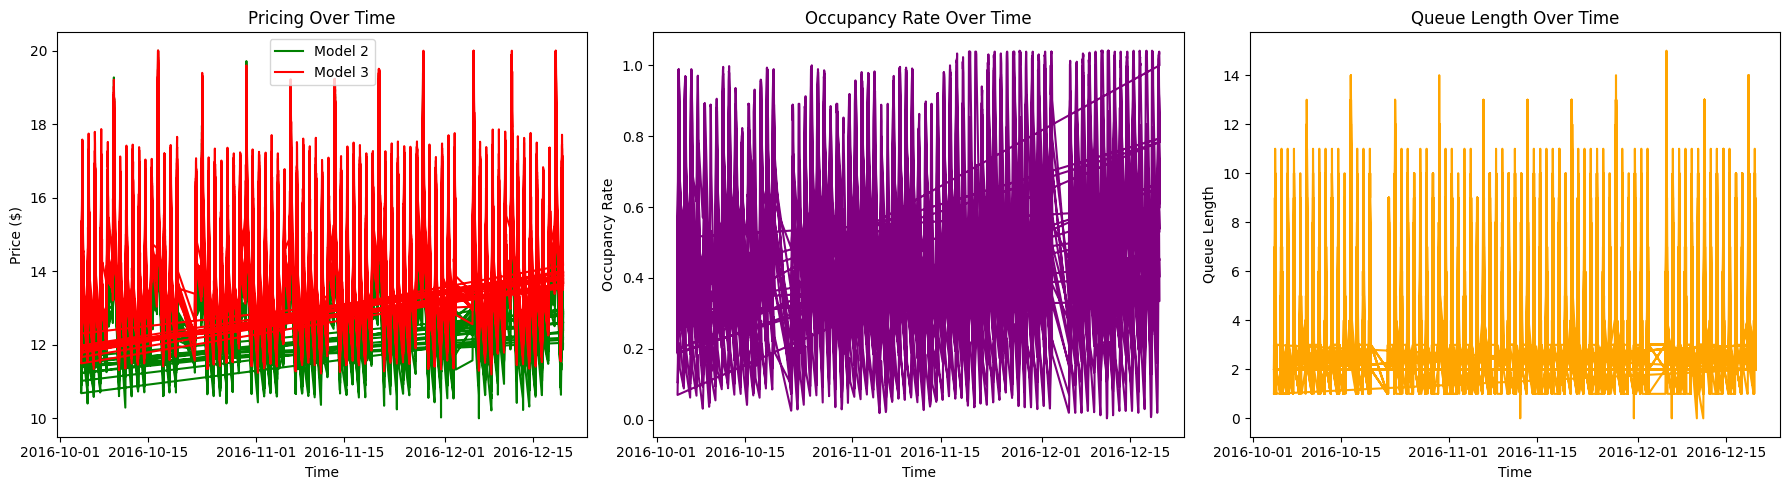

Performance comparison plots created successfully


In [382]:
plot_performance_comparison(df_sorted, df_model2)

In [383]:
def plot_geographic_heatmap(df):
    """Create geographic heatmap with error handling"""
    try:
        if df is None:
            print("Dataframe is None, cannot create heatmap")
            return

        required_cols = ['SystemCodeNumber', 'Latitude', 'Longitude', 'Model3Price', 'Occupancy', 'Capacity']
        missing_cols = [col for col in required_cols if col not in df.columns]

        if missing_cols:
            print(f"Missing columns for heatmap: {missing_cols}")
            return

        # Get latest data for each lot
        latest = df.groupby('SystemCodeNumber').agg({
            'Latitude': 'first',
            'Longitude': 'first',
            'Model3Price': 'mean',
            'Occupancy': 'mean',
            'Capacity': 'first'
        }).reset_index()

        # Remove rows with invalid coordinates
        latest = latest.dropna(subset=['Latitude', 'Longitude'])

        if len(latest) == 0:
            print("No valid geographic data found")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Price heatmap
        sc1 = ax1.scatter(latest['Longitude'], latest['Latitude'],
                         c=latest['Model3Price'], s=100, cmap='viridis', alpha=0.7)
        plt.colorbar(sc1, ax=ax1, label='Average Price ($)')
        ax1.set_title('Geographic Pricing Heatmap')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.grid(True, alpha=0.3)

        # Occupancy heatmap
        occupancy_rate = latest['Occupancy'] / latest['Capacity']
        sc2 = ax2.scatter(latest['Longitude'], latest['Latitude'],
                         c=occupancy_rate, s=100, cmap='RdYlGn', alpha=0.7)
        plt.colorbar(sc2, ax=ax2, label='Average Occupancy Rate')
        ax2.set_title('Geographic Occupancy Heatmap')
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        print("Geographic heatmaps created successfully")

    except Exception as e:
        print(f"Error creating geographic heatmap: {e}")

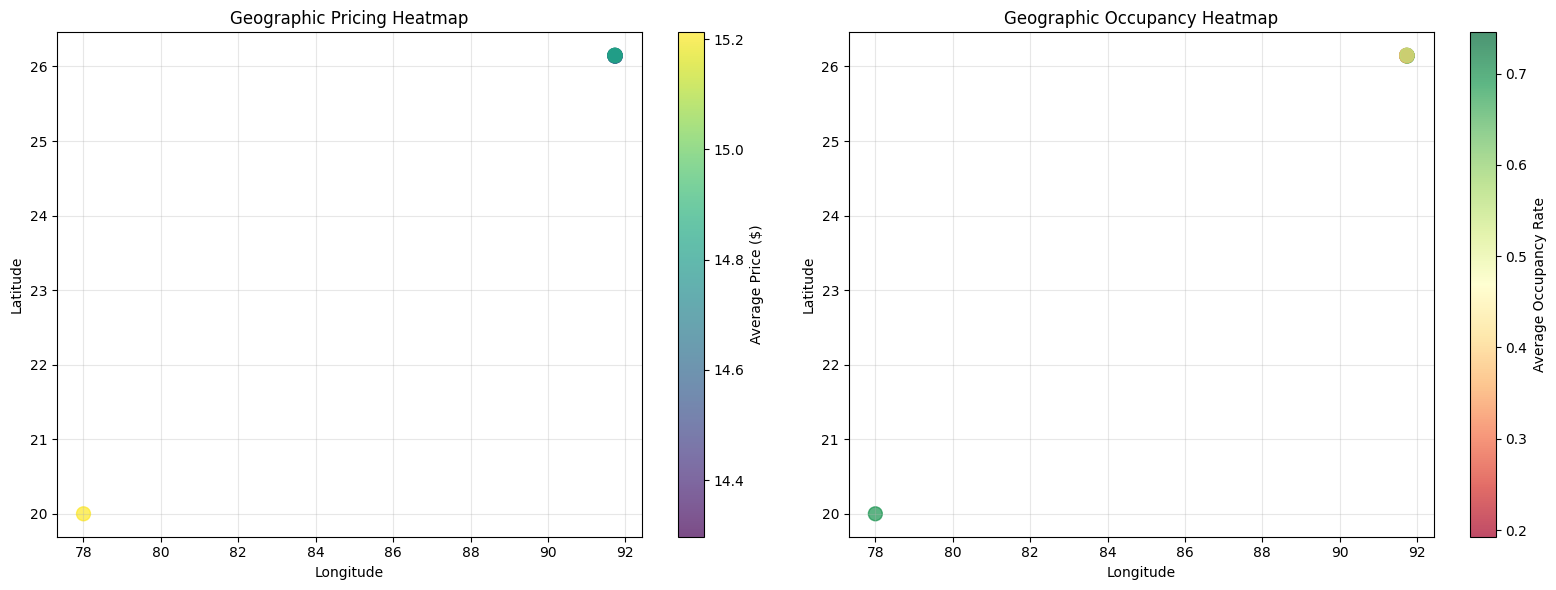

Geographic heatmaps created successfully


In [385]:
plot_geographic_heatmap(df_model2)

In [386]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points using Haversine formula"""
    try:
        R = 6371  # Earth's radius in kilometers
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return float('inf')

In [387]:
def find_nearby_lots(df, lot_id, max_km=2.0):
    """Find nearby parking lots within specified distance"""
    try:
        if df is None or lot_id not in df['SystemCodeNumber'].values:
            return []

        target_lot = df[df['SystemCodeNumber'] == lot_id].iloc[0]
        target_lat, target_lon = target_lot['Latitude'], target_lot['Longitude']

        nearby_lots = []
        for other_lot_id in df['SystemCodeNumber'].unique():
            if other_lot_id != lot_id:
                other_lot = df[df['SystemCodeNumber'] == other_lot_id].iloc[0]
                distance = calculate_distance(target_lat, target_lon,
                                           other_lot['Latitude'], other_lot['Longitude'])

                if distance <= max_km:
                    nearby_lots.append({
                        'lot_id': other_lot_id,
                        'distance_km': distance,
                        'latitude': other_lot['Latitude'],
                        'longitude': other_lot['Longitude']
                    })

        return sorted(nearby_lots, key=lambda x: x['distance_km'])

    except Exception as e:
        print(f"Error finding nearby lots: {e}")
        return []

In [388]:
def generate_rerouting_suggestions(df, lot_id, timestamp, max_km=2.0):
    """Generate smart rerouting suggestions when a lot is full"""
    try:
        if df is None:
            return []

        # Get current state of the problem lot
        problem_lot_data = df[(df['SystemCodeNumber'] == lot_id) &
                             (df['Timestamp'] == timestamp)]

        if problem_lot_data.empty:
            return []

        problem_lot = problem_lot_data.iloc[0]
        occupancy_ratio = problem_lot['Occupancy'] / problem_lot['Capacity']

        # Only suggest rerouting if lot is very full (>90%)
        if occupancy_ratio < 0.9:
            return []

        # Find nearby lots
        nearby_lots = find_nearby_lots(df, lot_id, max_km)

        suggestions = []
        for nearby_lot in nearby_lots:
            # Get current state of nearby lot
            nearby_lot_data = df[(df['SystemCodeNumber'] == nearby_lot['lot_id']) &
                               (df['Timestamp'] == timestamp)]

            if not nearby_lot_data.empty:
                nearby_lot_current = nearby_lot_data.iloc[0]
                nearby_occupancy_ratio = nearby_lot_current['Occupancy'] / nearby_lot_current['Capacity']

                # Suggest if nearby lot has space (<80% full) and is cheaper
                if (nearby_occupancy_ratio < 0.8 and
                    nearby_lot_current['Model3Price'] < problem_lot['Model3Price']):

                    suggestions.append({
                        'lot_id': nearby_lot['lot_id'],
                        'distance_km': nearby_lot['distance_km'],
                        'current_price': nearby_lot_current['Model3Price'],
                        'occupancy_rate': nearby_occupancy_ratio,
                        'savings': problem_lot['Model3Price'] - nearby_lot_current['Model3Price']
                    })

        return suggestions

    except Exception as e:
        print(f"Error generating rerouting suggestions: {e}")
        return []

In [389]:
generate_rerouting_suggestions

<function __main__.generate_rerouting_suggestions(df, lot_id, timestamp, max_km=2.0)>

In [390]:
def test_rerouting_system(df, sample_lots=3):
    """Test the rerouting system with sample data"""
    try:
        print("Testing Smart Rerouting System...")
        print("=" * 50)

        if df is None or len(df) == 0:
            print("No data available for rerouting test")
            return

        # Sample some timestamps for testing
        unique_timestamps = df['Timestamp'].unique()
        if len(unique_timestamps) < sample_lots:
            sample_lots = len(unique_timestamps)

        sample_timestamps = unique_timestamps[::len(unique_timestamps)//sample_lots][:sample_lots]

        total_suggestions = 0

        for i, timestamp in enumerate(sample_timestamps):
            print(f"\nTesting timestamp: {timestamp}")

            # Find lots with high occupancy
            timestamp_data = df[df['Timestamp'] == timestamp]
            high_occupancy_lots = timestamp_data[timestamp_data['Occupancy'] / timestamp_data['Capacity'] > 0.9]

            if not high_occupancy_lots.empty:
                # Test with the first high occupancy lot
                problem_lot = high_occupancy_lots.iloc[0]
                suggestions = generate_rerouting_suggestions(df, problem_lot['SystemCodeNumber'], timestamp)

                print(f"Problem lot: {problem_lot['SystemCodeNumber']}")
                print(f"Occupancy: {problem_lot['Occupancy']}/{problem_lot['Capacity']} ({problem_lot['Occupancy']/problem_lot['Capacity']:.1%})")
                print(f"Current price: ${problem_lot['Model3Price']:.2f}")

                if suggestions:
                    print(f"Found {len(suggestions)} rerouting suggestions:")
                    for suggestion in suggestions:
                        print(f" {suggestion['lot_id']} ({suggestion['distance_km']:.1f}km)")
                        print(f"Price: ${suggestion['current_price']:.2f} (Save: ${suggestion['savings']:.2f})")
                        print(f"Occupancy: {suggestion['occupancy_rate']:.1%}")
                    total_suggestions += len(suggestions)
                else:
                    print("No suitable alternatives found")
            else:
                print("No overcrowded lots at this time")

        print(f"\nRerouting System Summary:")
        print(f"Total suggestions generated: {total_suggestions}")
        print(f"Average suggestions per test: {total_suggestions/sample_lots:.1f}")

    except Exception as e:
        print(f"Error testing rerouting system: {e}")


In [391]:
test_rerouting_system

<function __main__.test_rerouting_system(df, sample_lots=3)>

In [396]:
def add_comprehensive_performance_evaluation(df1, df2):

    try:
        print("Adding Comprehensive Performance Evaluation...")
        print("=" * 60)

        if df1 is None or df2 is None:
            print("Dataframes are None, cannot evaluate performance")
            return None

        # Calculate total revenue for each model
        model1_total_revenue = df1['Revenue'].sum() if 'Revenue' in df1.columns else 0
        model2_total_revenue = df2['Model2Revenue'].sum() if 'Model2Revenue' in df2.columns else 0
        model3_total_revenue = df2['Model3Revenue'].sum() if 'Model3Revenue' in df2.columns else 0

        print("=== REVENUE PERFORMANCE COMPARISON ===")
        print(f"Model 1 (Baseline):     ${model1_total_revenue:,.2f}")
        print(f"Model 2 (Demand-Based): ${model2_total_revenue:,.2f}")
        print(f"Model 3 (Competitive):  ${model3_total_revenue:,.2f}")

        if model1_total_revenue > 0:
            print(f"\nRevenue Improvements:")
            if model2_total_revenue > 0:
                print(f"Model 2 vs Model 1: {((model2_total_revenue/model1_total_revenue - 1) * 100):.2f}%")
            if model3_total_revenue > 0:
                print(f"Model 3 vs Model 1: {((model3_total_revenue/model1_total_revenue - 1) * 100):.2f}%")
            if model2_total_revenue > 0 and model3_total_revenue > 0:
                print(f"Model 3 vs Model 2: {((model3_total_revenue/model2_total_revenue - 1) * 100):.2f}%")

        # Calculate utilization metrics
        def calculate_utilization_metrics(df, price_col, revenue_col):
            try:
                avg_occupancy_rate = (df['Occupancy'] / df['Capacity']).mean() if 'Occupancy' in df.columns and 'Capacity' in df.columns else 0
                avg_price = df[price_col].mean() if price_col in df.columns else 0
                revenue_per_space = df[revenue_col].sum() / df['Capacity'].sum() if revenue_col in df.columns and 'Capacity' in df.columns else 0
                price_volatility = df[price_col].std() / df[price_col].mean() if price_col in df.columns and df[price_col].mean() > 0 else 0
                max_price = df[price_col].max() if price_col in df.columns else 0
                min_price = df[price_col].min() if price_col in df.columns else 0

                return {
                    'avg_occupancy_rate': avg_occupancy_rate,
                    'avg_price': avg_price,
                    'revenue_per_space': revenue_per_space,
                    'price_volatility': price_volatility,
                    'max_price': max_price,
                    'min_price': min_price
                }
            except Exception as e:
                print(f"Error calculating utilization metrics: {e}")
                return {
                    'avg_occupancy_rate': 0, 'avg_price': 0, 'revenue_per_space': 0,
                    'price_volatility': 0, 'max_price': 0, 'min_price': 0
                }

        model1_metrics = calculate_utilization_metrics(df1, 'BaselinePrice', 'Revenue')
        model2_metrics = calculate_utilization_metrics(df2, 'Model2Price', 'Model2Revenue')
        model3_metrics = calculate_utilization_metrics(df2, 'Model3Price', 'Model3Revenue')

        print("\n=== OCCUPANCY & UTILIZATION METRICS ===")
        print(f"{'Metric':<25} {'Model 1':<12} {'Model 2':<12} {'Model 3':<12}")
        print("-" * 65)
        print(f"{'Avg Occupancy Rate':<25} {model1_metrics['avg_occupancy_rate']:.3f}     {model2_metrics['avg_occupancy_rate']:.3f}     {model3_metrics['avg_occupancy_rate']:.3f}")
        print(f"{'Avg Price ($)':<25} {model1_metrics['avg_price']:.2f}     {model2_metrics['avg_price']:.2f}     {model3_metrics['avg_price']:.2f}")
        print(f"{'Revenue per Space ($)':<25} {model1_metrics['revenue_per_space']:.2f}     {model2_metrics['revenue_per_space']:.2f}     {model3_metrics['revenue_per_space']:.2f}")
        print(f"{'Price Volatility':<25} {model1_metrics['price_volatility']:.3f}     {model2_metrics['price_volatility']:.3f}     {model3_metrics['price_volatility']:.3f}")
        print(f"{'Price Range ($)':<25} {model1_metrics['min_price']:.2f}-{model1_metrics['max_price']:.2f} {model2_metrics['min_price']:.2f}-{model2_metrics['max_price']:.2f} {model3_metrics['min_price']:.2f}-{model3_metrics['max_price']:.2f}")

        # Create comprehensive performance comparison plots
        try:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')

            # Revenue comparison
            axes[0, 0].bar(['Model 1', 'Model 2', 'Model 3'],
                           [model1_total_revenue, model2_total_revenue, model3_total_revenue],
                           color=['skyblue', 'lightgreen', 'lightcoral'])
            axes[0, 0].set_title('Total Revenue Comparison')
            axes[0, 0].set_ylabel('Total Revenue ($)')
            axes[0, 0].ticklabel_format(style='plain', axis='y')

            # Occupancy rate comparison
            axes[0, 1].bar(['Model 1', 'Model 2', 'Model 3'],
                           [model1_metrics['avg_occupancy_rate'], model2_metrics['avg_occupancy_rate'], model3_metrics['avg_occupancy_rate']],
                           color=['skyblue', 'lightgreen', 'lightcoral'])
            axes[0, 1].set_title('Average Occupancy Rate')
            axes[0, 1].set_ylabel('Occupancy Rate')

            # Price volatility comparison
            axes[0, 2].bar(['Model 1', 'Model 2', 'Model 3'],
                           [model1_metrics['price_volatility'], model2_metrics['price_volatility'], model3_metrics['price_volatility']],
                           color=['skyblue', 'lightgreen', 'lightcoral'])
            axes[0, 2].set_title('Price Volatility (Lower is Better)')
            axes[0, 2].set_ylabel('Coefficient of Variation')

            # Revenue per space comparison
            axes[1, 0].bar(['Model 1', 'Model 2', 'Model 3'],
                           [model1_metrics['revenue_per_space'], model2_metrics['revenue_per_space'], model3_metrics['revenue_per_space']],
                           color=['skyblue', 'lightgreen', 'lightcoral'])
            axes[1, 0].set_title('Revenue per Parking Space')
            axes[1, 0].set_ylabel('Revenue per Space ($)')

            # Average price comparison
            axes[1, 1].bar(['Model 1', 'Model 2', 'Model 3'],
                           [model1_metrics['avg_price'], model2_metrics['avg_price'], model3_metrics['avg_price']],
                           color=['skyblue', 'lightgreen', 'lightcoral'])
            axes[1, 1].set_title('Average Price')
            axes[1, 1].set_ylabel('Price ($)')

            # Price range comparison
            price_ranges = [
                model1_metrics['max_price'] - model1_metrics['min_price'],
                model2_metrics['max_price'] - model2_metrics['min_price'],
                model3_metrics['max_price'] - model3_metrics['min_price']
            ]
            axes[1, 2].bar(['Model 1', 'Model 2', 'Model 3'], price_ranges,
                           color=['skyblue', 'lightgreen', 'lightcoral'])
            axes[1, 2].set_title('Price Range')
            axes[1, 2].set_ylabel('Price Range ($)')

            plt.tight_layout()
            plt.show()
            print("Performance comparison plots created successfully")

        except Exception as e:
            print(f"Error creating performance plots: {e}")

        # Return metrics for further analysis
        return {
            'model1_metrics': model1_metrics,
            'model2_metrics': model2_metrics,
            'model3_metrics': model3_metrics,
            'revenues': {
                'model1': model1_total_revenue,
                'model2': model2_total_revenue,
                'model3': model3_total_revenue
            }
        }

    except Exception as e:
        print(f"Error in performance evaluation: {e}")
        return None

# --- Main Integration Function ---
def integrate_complete_solution(df_model2):
    """Main function to integrate all components"""
    try:
        print("Starting Complete Dynamic Pricing Integration...")
        print("=" * 60)

        if df_model2 is None or len(df_model2) == 0:
            print("No data provided for integration")
            return None

        # Step 1: Prepare data for Pathway
        pathway_data = prepare_pathway_data(df_model2)

        # Step 2: Create visualizations
        print("\nCreating visualizations...")
        plot_performance_comparison(df_model2, df_model2)
        plot_geographic_heatmap(df_model2)

        # Step 3: Test rerouting system
        print("\nTesting rerouting system...")
        test_rerouting_system(df_model2)

        # Step 4: Performance evaluation
        print("\nRunning performance evaluation...")
        performance_metrics = add_comprehensive_performance_evaluation(df_model2, df_model2)

        # Step 5: Pathway integration (if available)
        if pathway_available and pathway_data is not None:
            print("\n⚡ Setting up Pathway integration...")
            model1_stream, model2_stream, model3_stream = create_realtime_pricing_pipeline()

            if model3_stream is not None:
                print("Pathway integration successful!")
                print("To start real-time processing, run: pw.run()")
            else:
                print("Pathway pipeline creation failed")
        else:
            print("Pathway not available - skipping real-time integration")

        print("\nIntegration complete! All components are ready.")
        return performance_metrics

    except Exception as e:
        print(f"Error in complete integration: {e}")
        return None


if __name__ == "__main__":
    print("📝 Complete Dynamic Pricing Solution")
    print("=" * 60)
    print("All functions are ready to use!")
    print("To use this code:")
    print("   1. Load your data: df_model2 = pd.read_csv('dataset.csv')")
    print("   2. Run integration: integrate_complete_solution(df_model2)")
    print("   3. All visualizations and analysis will be created automatically")
    print("=" * 60)

📝 Complete Dynamic Pricing Solution
All functions are ready to use!
To use this code:
   1. Load your data: df_model2 = pd.read_csv('dataset.csv')
   2. Run integration: integrate_complete_solution(df_model2)
   3. All visualizations and analysis will be created automatically


Adding Comprehensive Performance Evaluation...
=== REVENUE PERFORMANCE COMPARISON ===
Model 1 (Baseline):     $264,884,048.56
Model 2 (Demand-Based): $188,203,234.48
Model 3 (Competitive):  $201,525,149.30

Revenue Improvements:
Model 2 vs Model 1: -28.95%
Model 3 vs Model 1: -23.92%
Model 3 vs Model 2: 7.08%

=== OCCUPANCY & UTILIZATION METRICS ===
Metric                    Model 1      Model 2      Model 3     
-----------------------------------------------------------------
Avg Occupancy Rate        0.509     0.509     0.509
Avg Price ($)             19.72     13.69     14.71
Revenue per Space ($)     8.98     6.38     6.83
Price Volatility          0.067     0.114     0.109
Price Range ($)           10.02-20.00 10.00-20.00 11.19-20.00


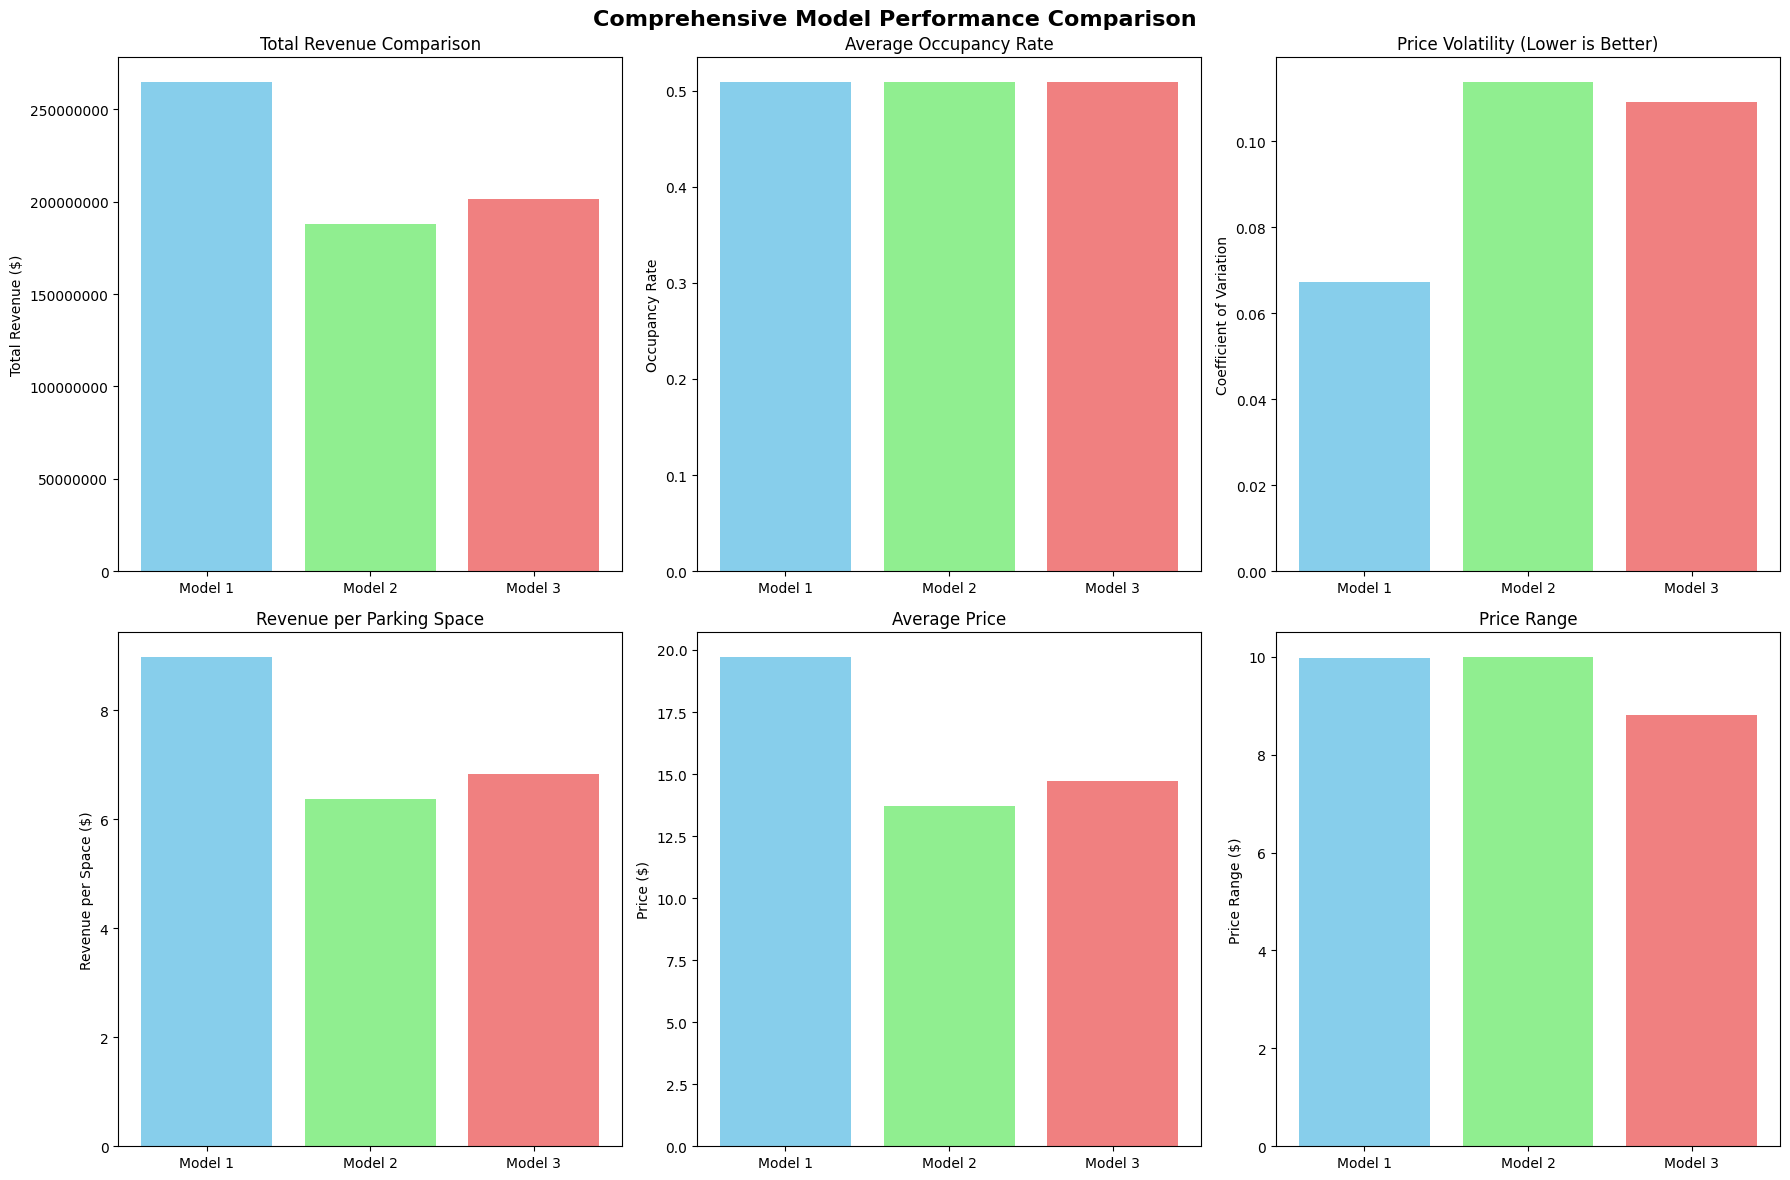

Performance comparison plots created successfully


{'model1_metrics': {'avg_occupancy_rate': np.float64(0.5091186620566392),
  'avg_price': np.float64(19.724724168436598),
  'revenue_per_space': np.float64(8.983817456174023),
  'price_volatility': np.float64(0.0671773034270066),
  'max_price': 20.0,
  'min_price': 10.020870495897253},
 'model2_metrics': {'avg_occupancy_rate': np.float64(0.5091186620566392),
  'avg_price': np.float64(13.694112351371286),
  'revenue_per_space': np.float64(6.383108052005137),
  'price_volatility': np.float64(0.11376800616918853),
  'max_price': 20.0,
  'min_price': 10.0},
 'model3_metrics': {'avg_occupancy_rate': np.float64(0.5091186620566392),
  'avg_price': np.float64(14.712120382759233),
  'revenue_per_space': np.float64(6.834934621327078),
  'price_volatility': np.float64(0.10916690457005802),
  'max_price': 20.0,
  'min_price': 11.19423638663119},
 'revenues': {'model1': np.float64(264884048.55668968),
  'model2': np.float64(188203234.47555742),
  'model3': np.float64(201525149.29754946)}}

In [397]:
add_comprehensive_performance_evaluation(df_sorted, df_model2)

## Initial data exploration visualization

### Subtask:
Add plots to visualize the distribution of features in the raw data.

**Reasoning**:
Create histograms for 'Capacity' and 'Occupancy' and bar plots for 'VehicleType' and 'TrafficConditionNearby' to visualize their distributions in the original dataframe as requested by the instructions.

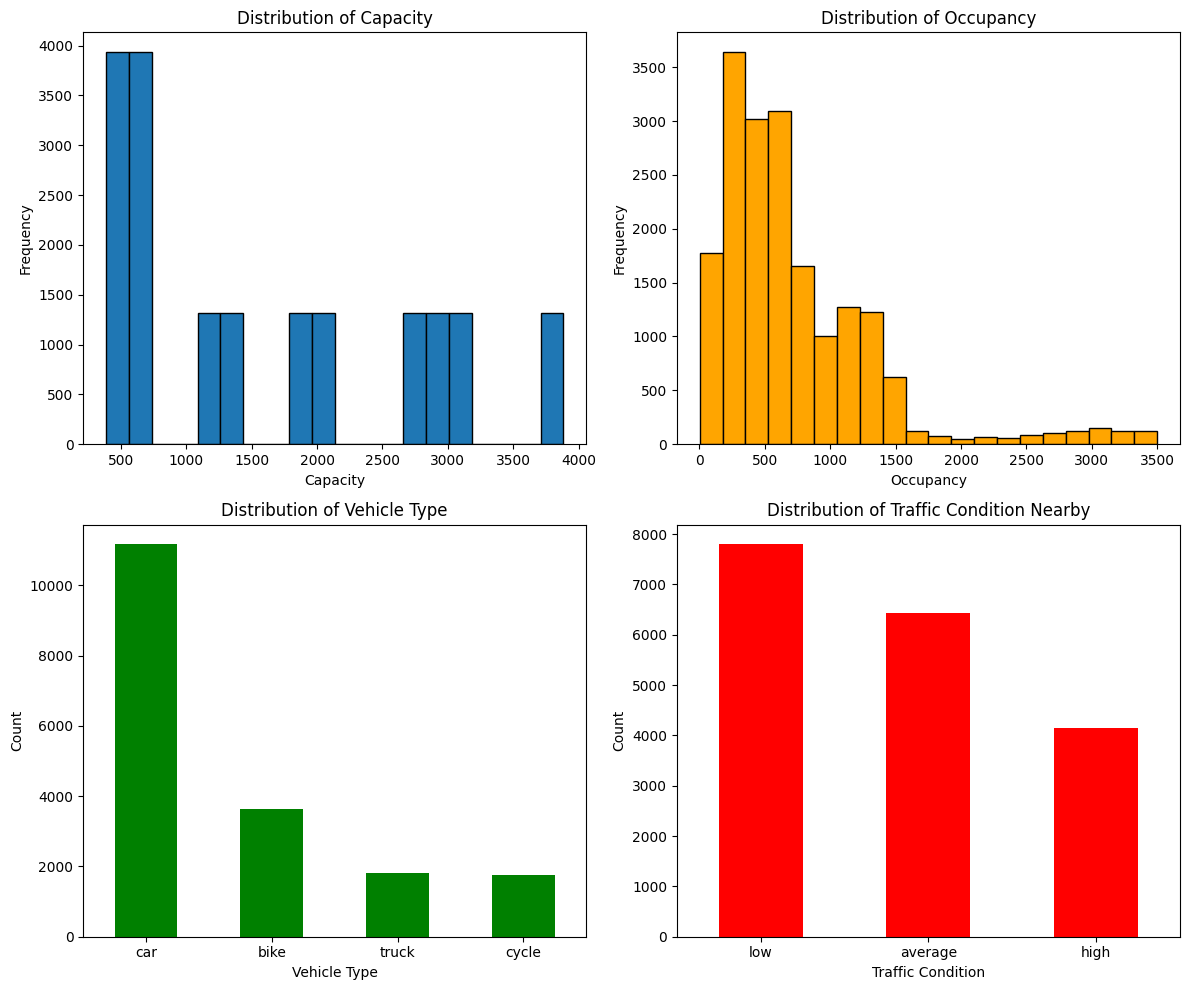

In [406]:
plt.figure(figsize=(12, 10))

# Histogram for Capacity
plt.subplot(2, 2, 1)
plt.hist(df['Capacity'], bins=20, edgecolor='black')
plt.title('Distribution of Capacity')
plt.xlabel('Capacity')
plt.ylabel('Frequency')

# Histogram for Occupancy
plt.subplot(2, 2, 2)
plt.hist(df['Occupancy'], bins=20, edgecolor='black', color='orange')
plt.title('Distribution of Occupancy')
plt.xlabel('Occupancy')
plt.ylabel('Frequency')

# Bar plot for VehicleType
plt.subplot(2, 2, 3)
df['VehicleType'].value_counts().plot(kind='bar', color='green')
plt.title('Distribution of Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Bar plot for TrafficConditionNearby
plt.subplot(2, 2, 4)
df['TrafficConditionNearby'].value_counts().plot(kind='bar', color='red')
plt.title('Distribution of Traffic Condition Nearby')
plt.xlabel('Traffic Condition')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Model 1 visualization enhancement

### Subtask:
Review and enhance the visualization of Model 1's pricing behavior.

**Reasoning**:
Create a Matplotlib plot to visualize the baseline price over time for a single parking lot, which directly addresses steps 1-8 of the subtask.

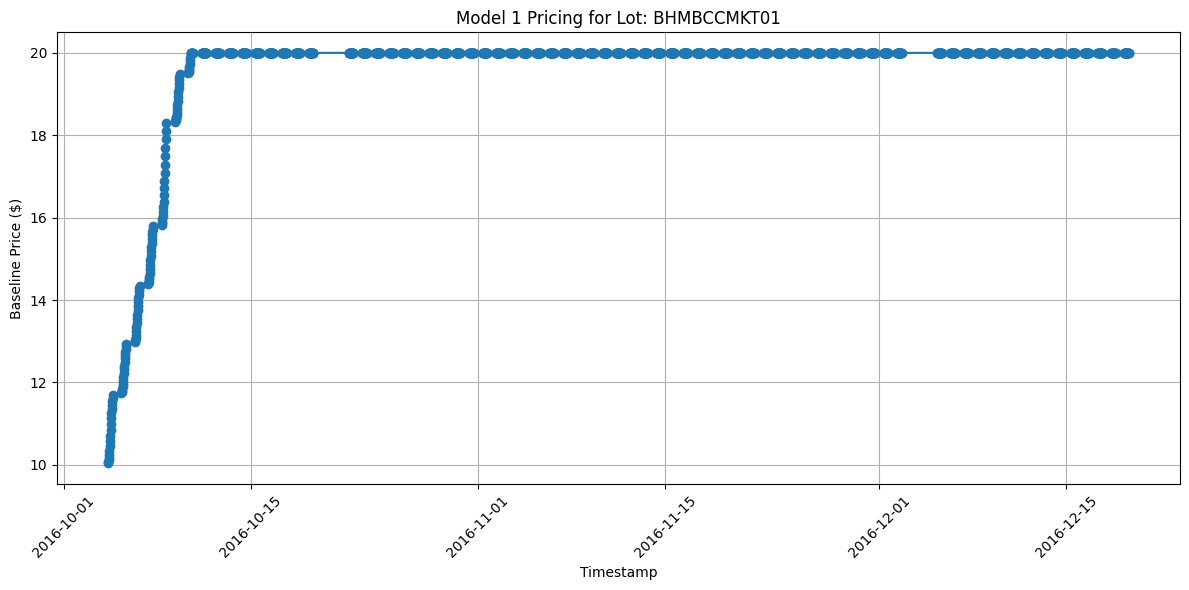

In [407]:
plt.figure(figsize=(12, 6))
plt.plot(df_lot['Timestamp'], df_lot['BaselinePrice'], marker='o', linestyle='-')
plt.title(f"Model 1 Pricing for Lot: {first_lot}")
plt.xlabel("Timestamp")
plt.ylabel("Baseline Price ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model 2 visualization enhancement

### Subtask:
Add visualizations to show the impact of individual demand features on the price.

**Reasoning**:
Generate scatter plots to visualize the relationship between `Model2Price` and various demand features.

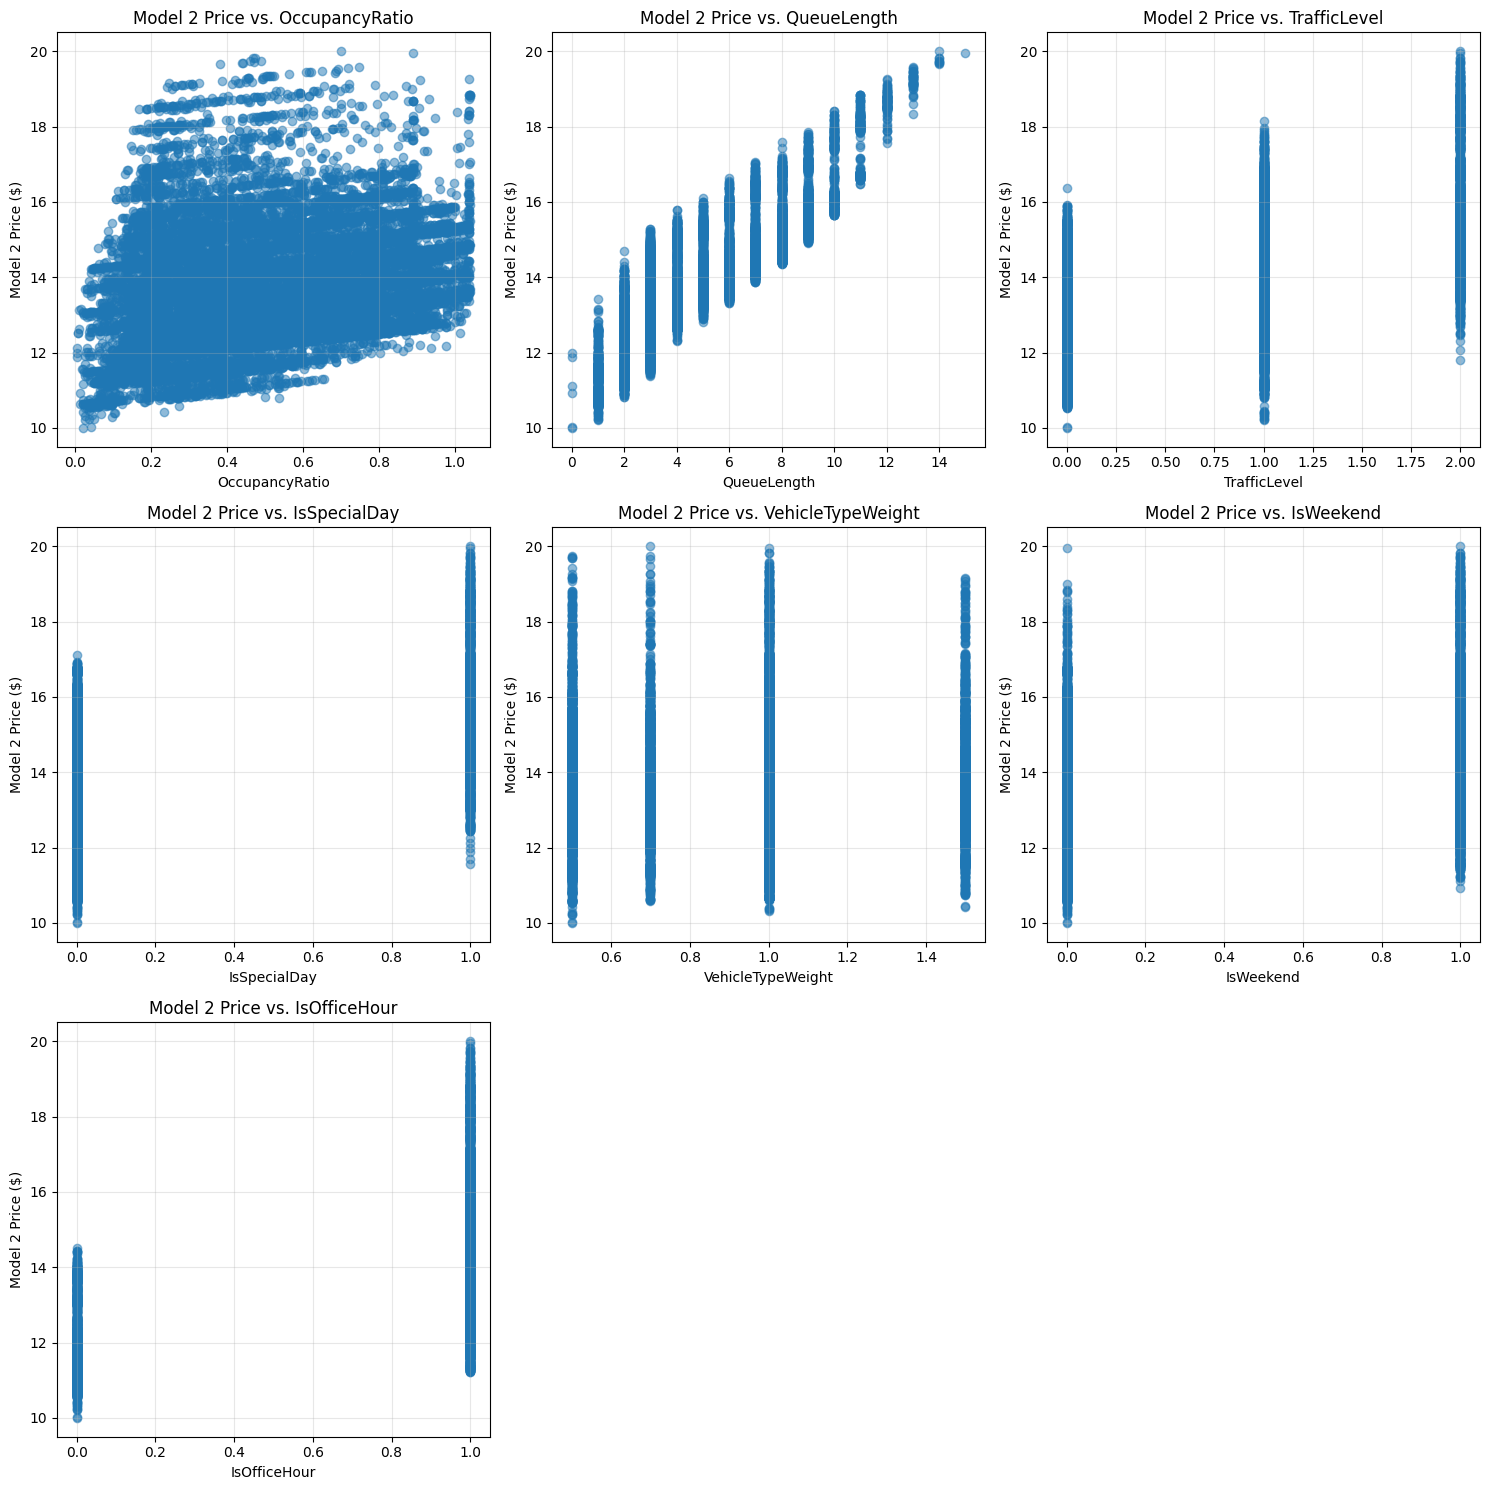

In [408]:
import matplotlib.pyplot as plt

# Define the features to plot against Model2Price
demand_features = ['OccupancyRatio', 'QueueLength', 'TrafficLevel',
                   'IsSpecialDay', 'VehicleTypeWeight', 'IsWeekend', 'IsOfficeHour']

# Create a figure and axes for the plots
n_features = len(demand_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Generate scatter plots
for i, feature in enumerate(demand_features):
    ax = axes[i]
    ax.scatter(df_model2[feature], df_model2['Model2Price'], alpha=0.5)
    ax.set_title(f"Model 2 Price vs. {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Model 2 Price ($)")
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Model 3 visualization enhancement

### Subtask:
Add visualizations to show the influence of competitive factors on the price.

**Reasoning**:
Create scatter plots to visualize the relationship between Model3Price and the competitive factors NearbyAvgPrice and NearbyAvgOccupancyRatio.

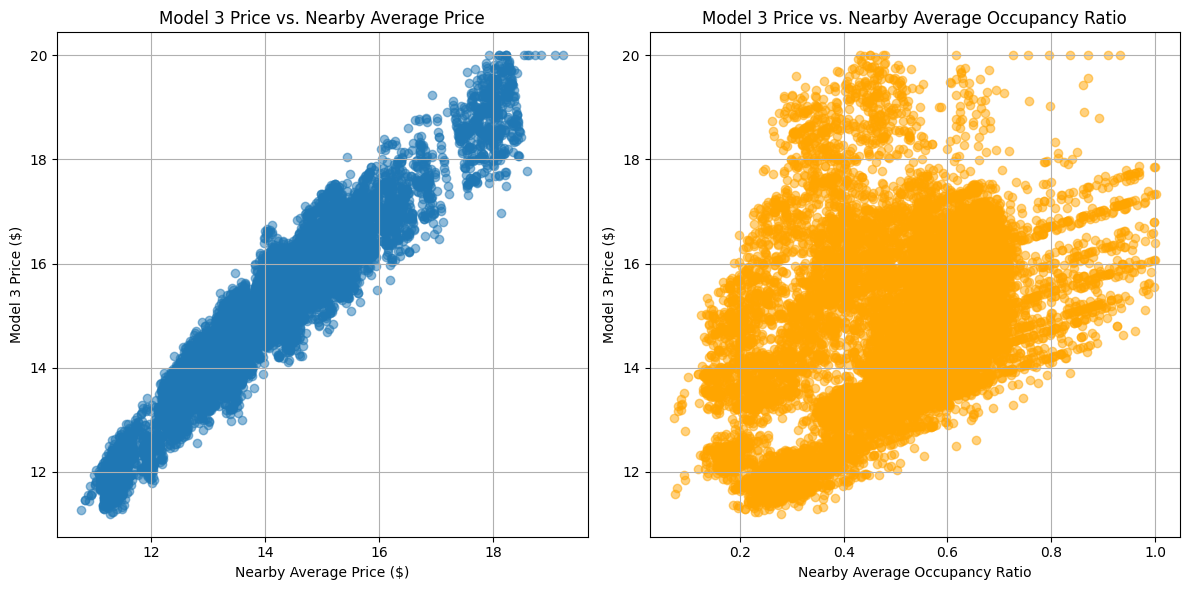

In [409]:
plt.figure(figsize=(12, 6))

# Scatter plot for Model3Price vs NearbyAvgPrice
plt.subplot(1, 2, 1)
plt.scatter(df_model2['NearbyAvgPrice'], df_model2['Model3Price'], alpha=0.5)
plt.title("Model 3 Price vs. Nearby Average Price")
plt.xlabel("Nearby Average Price ($)")
plt.ylabel("Model 3 Price ($)")
plt.grid(True)

# Scatter plot for Model3Price vs NearbyAvgOccupancyRatio
plt.subplot(1, 2, 2)
plt.scatter(df_model2['NearbyAvgOccupancyRatio'], df_model2['Model3Price'], alpha=0.5, color='orange')
plt.title("Model 3 Price vs. Nearby Average Occupancy Ratio")
plt.xlabel("Nearby Average Occupancy Ratio")
plt.ylabel("Model 3 Price ($)")
plt.grid(True)

plt.tight_layout()
plt.show()

## Rerouting system visualization

### Subtask:
Create a plot to visualize rerouting suggestions on a map.

**Reasoning**:
Define a function to plot rerouting suggestions on a map and then call it with sample data.

Attempting to plot rerouting for Lot: BHMBCCMKT01 at Timestamp: 2016-11-19 14:04:00


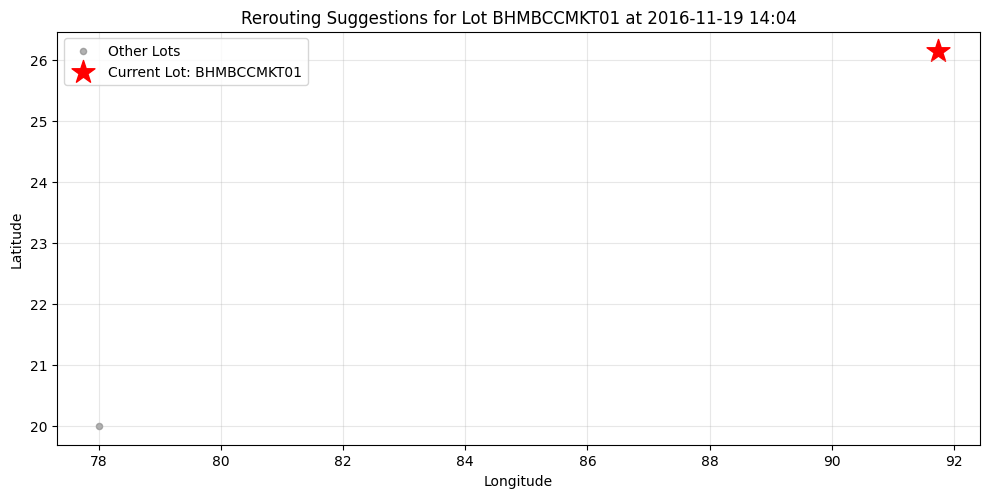

In [410]:
def plot_rerouting_suggestions(df, lot_id, timestamp, max_distance_km=5.0):
    """
    Plots rerouting suggestions on a map for a specific lot and timestamp.

    Parameters:
    - df: DataFrame with all parking data, including location and prices.
    - lot_id: Current parking lot ID.
    - timestamp: Current timestamp.
    - max_distance_km: Maximum distance for suggestions in km.
    """
    try:
        # Get suggestions
        suggestions = generate_rerouting_suggestions(df, lot_id, timestamp, max_distance_km)

        # Filter data for the specific timestamp
        timestamp_data = df[df['Timestamp'] == timestamp].copy()

        if timestamp_data.empty:
            print(f"No data found for timestamp: {timestamp}")
            return

        # Get current lot's location and price
        current_lot_data = timestamp_data[timestamp_data['SystemCodeNumber'] == lot_id]

        if current_lot_data.empty:
            print(f"Current lot '{lot_id}' not found at timestamp: {timestamp}")
            return

        current_lat = current_lot_data.iloc[0]['Latitude']
        current_lon = current_lot_data.iloc[0]['Longitude']
        current_price = current_lot_data.iloc[0]['Model3Price']

        plt.figure(figsize=(10, 8))

        # Plot all lots for the timestamp
        plt.scatter(timestamp_data['Longitude'], timestamp_data['Latitude'],
                    color='gray', s=20, alpha=0.6, label='Other Lots')

        # Plot the current lot
        plt.scatter(current_lon, current_lat, color='red', marker='*', s=300, label=f'Current Lot: {lot_id}')

        # Plot suggested lots
        if suggestions:
            suggested_lats = [s['latitude'] for s in suggestions]
            suggested_lons = [s['longitude'] for s in suggestions]
            suggested_labels = [f"{s['lot_id']} ({s['distance_km']:.1f}km, ${s['current_price']:.2f})" for s in suggestions]

            plt.scatter(suggested_lons, suggested_lats, color='green', marker='o', s=150, label='Suggested Lots')

            # Add annotations for suggested lots
            for i, suggestion in enumerate(suggestions):
                plt.annotate(suggested_labels[i], (suggested_lons[i], suggested_lats[i]),
                             textcoords="offset points", xytext=(10,10), ha='left', fontsize=9)

        plt.title(f"Rerouting Suggestions for Lot {lot_id} at {timestamp.strftime('%Y-%m-%d %H:%M')}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting rerouting suggestions: {e}")

# Test the plotting function with sample data
# Pick a lot that is likely to be full at some point and a timestamp
test_lot_id = df_model2['SystemCodeNumber'].unique()[0] # First lot
test_timestamp_index = df_model2[df_model2['SystemCodeNumber'] == test_lot_id].head(1).index[0] # First entry of the lot

# Find a timestamp where occupancy is high for the test lot
high_occupancy_timestamps = df_model2[
    (df_model2['SystemCodeNumber'] == test_lot_id) &
    (df_model2['Occupancy'] / df_model2['Capacity'] > 0.8)
]['Timestamp']

if not high_occupancy_timestamps.empty:
    test_timestamp = high_occupancy_timestamps.iloc[0] # Use the first high occupancy timestamp
else:
    test_timestamp = df_model2['Timestamp'].iloc[0] # Default to first timestamp if no high occupancy found

print(f"Attempting to plot rerouting for Lot: {test_lot_id} at Timestamp: {test_timestamp}")
plot_rerouting_suggestions(df_model2, test_lot_id, test_timestamp)